In [224]:
%matplotlib inline
from __future__ import division, print_function

import os, sys
sys.path.append("../")

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import gc_colors
import pandas as pd
import STUDENT
import glob
import re
import TBFunctions as TB
import danplotlib as dpl
import numpy as np
import root_numpy as rn
from itertools import izip
from uncertainties import ufloat, unumpy

reload(TB)

plt.style.use("presentation")
gc_colors.update_colorcycle()

# Defines

In [148]:
def root2DF(*args, **kwargs):
    return pd.DataFrame( rn.root2array(*args, **kwargs) )

# Read Data

In [256]:
folder = "/auto/data/berninghoff/tb2017_2_Output/Test/"
layer2serial = { 0: "PACIFIC013", 1: "PACIFIC011" }
thresholds = [1.5, 2.5, 3.5]
PACIFIC_Thresholds = " ".join(map(str, thresholds))

SPIROC_ch_range = ["ADC_Ch_{}".format(ch) for ch in range(256, 384)]
SPIROC_ch_range_calib = ["Ch_{}".format(ch) for ch in range(256, 384)]
SPIROC_branches = rn.list_branches(folder+"SPIROC_ped_Layer0.root", "SPIROC")
SPIROC_keep_branches = [ br for br in SPIROC_branches if not "ADC_Ch" in br] + SPIROC_ch_range
SPIROC_keep_branches_particle = [ br for br in SPIROC_branches if not "ADC_Ch" in br] + SPIROC_ch_range + SPIROC_ch_range_calib

nEvents_PACIFIC = 400000
nEvents_SPIROC = 200000

In [257]:
PACIFIC = { "Layer0" : root2DF(folder+"PACIFIC_Layer0.root", "PACIFIC", stop=nEvents_PACIFIC),
            "Layer1" : root2DF(folder+"PACIFIC_Layer1.root", "PACIFIC", stop=nEvents_PACIFIC) 
          }
print("PACIFIC data read.")

SPIROC = { "Dark" : { "Layer0" : root2DF(folder+"SPIROC_ped_Layer0.root", "SPIROC", branches=SPIROC_keep_branches,
                                        stop=nEvents_SPIROC), 
                     "Layer1" : root2DF(folder+"SPIROC_ped_Layer1.root", "SPIROC", branches=SPIROC_keep_branches,
                                        stop=nEvents_SPIROC)
                   },
           "LED" : { "Layer0" : root2DF(folder+"SPIROC_led_Layer0.root", "SPIROC", branches=SPIROC_keep_branches,
                                        stop=nEvents_SPIROC), 
                     "Layer1" : root2DF(folder+"SPIROC_led_Layer1.root", "SPIROC", branches=SPIROC_keep_branches,
                                        stop=nEvents_SPIROC)
                   },
           "Particle" : { "Layer0" : root2DF(folder+"SPIROC_Layer0.root", "SPIROC", branches=SPIROC_keep_branches_particle,
                                             stop=nEvents_SPIROC), 
                          "Layer1" : root2DF(folder+"SPIROC_Layer1.root", "SPIROC", branches=SPIROC_keep_branches_particle,
                                             stop=nEvents_SPIROC)
                   }
         }
print("SPIROC data read.")

PACIFIC data read.
SPIROC data read.


In [258]:
print("PACIFIC Runs: {}".format(np.unique(PACIFIC["Layer0"]["Run_num"])))
print("SPIROC Pedestal run: {}".format(np.unique(SPIROC["Dark"]["Layer0"]["Run_num"])))
print("SPIROC LED run: {}".format(np.unique(SPIROC["LED"]["Layer0"]["Run_num"])))
print("SPIROC data run: {}".format(np.unique(SPIROC["Particle"]["Layer0"]["Run_num"])))

PACIFIC Runs: [1502121569]
SPIROC Pedestal run: [1502114849]
SPIROC LED run: [1502114875]
SPIROC data run: [1502114920 1502115044]


# Trigger vs finetiming

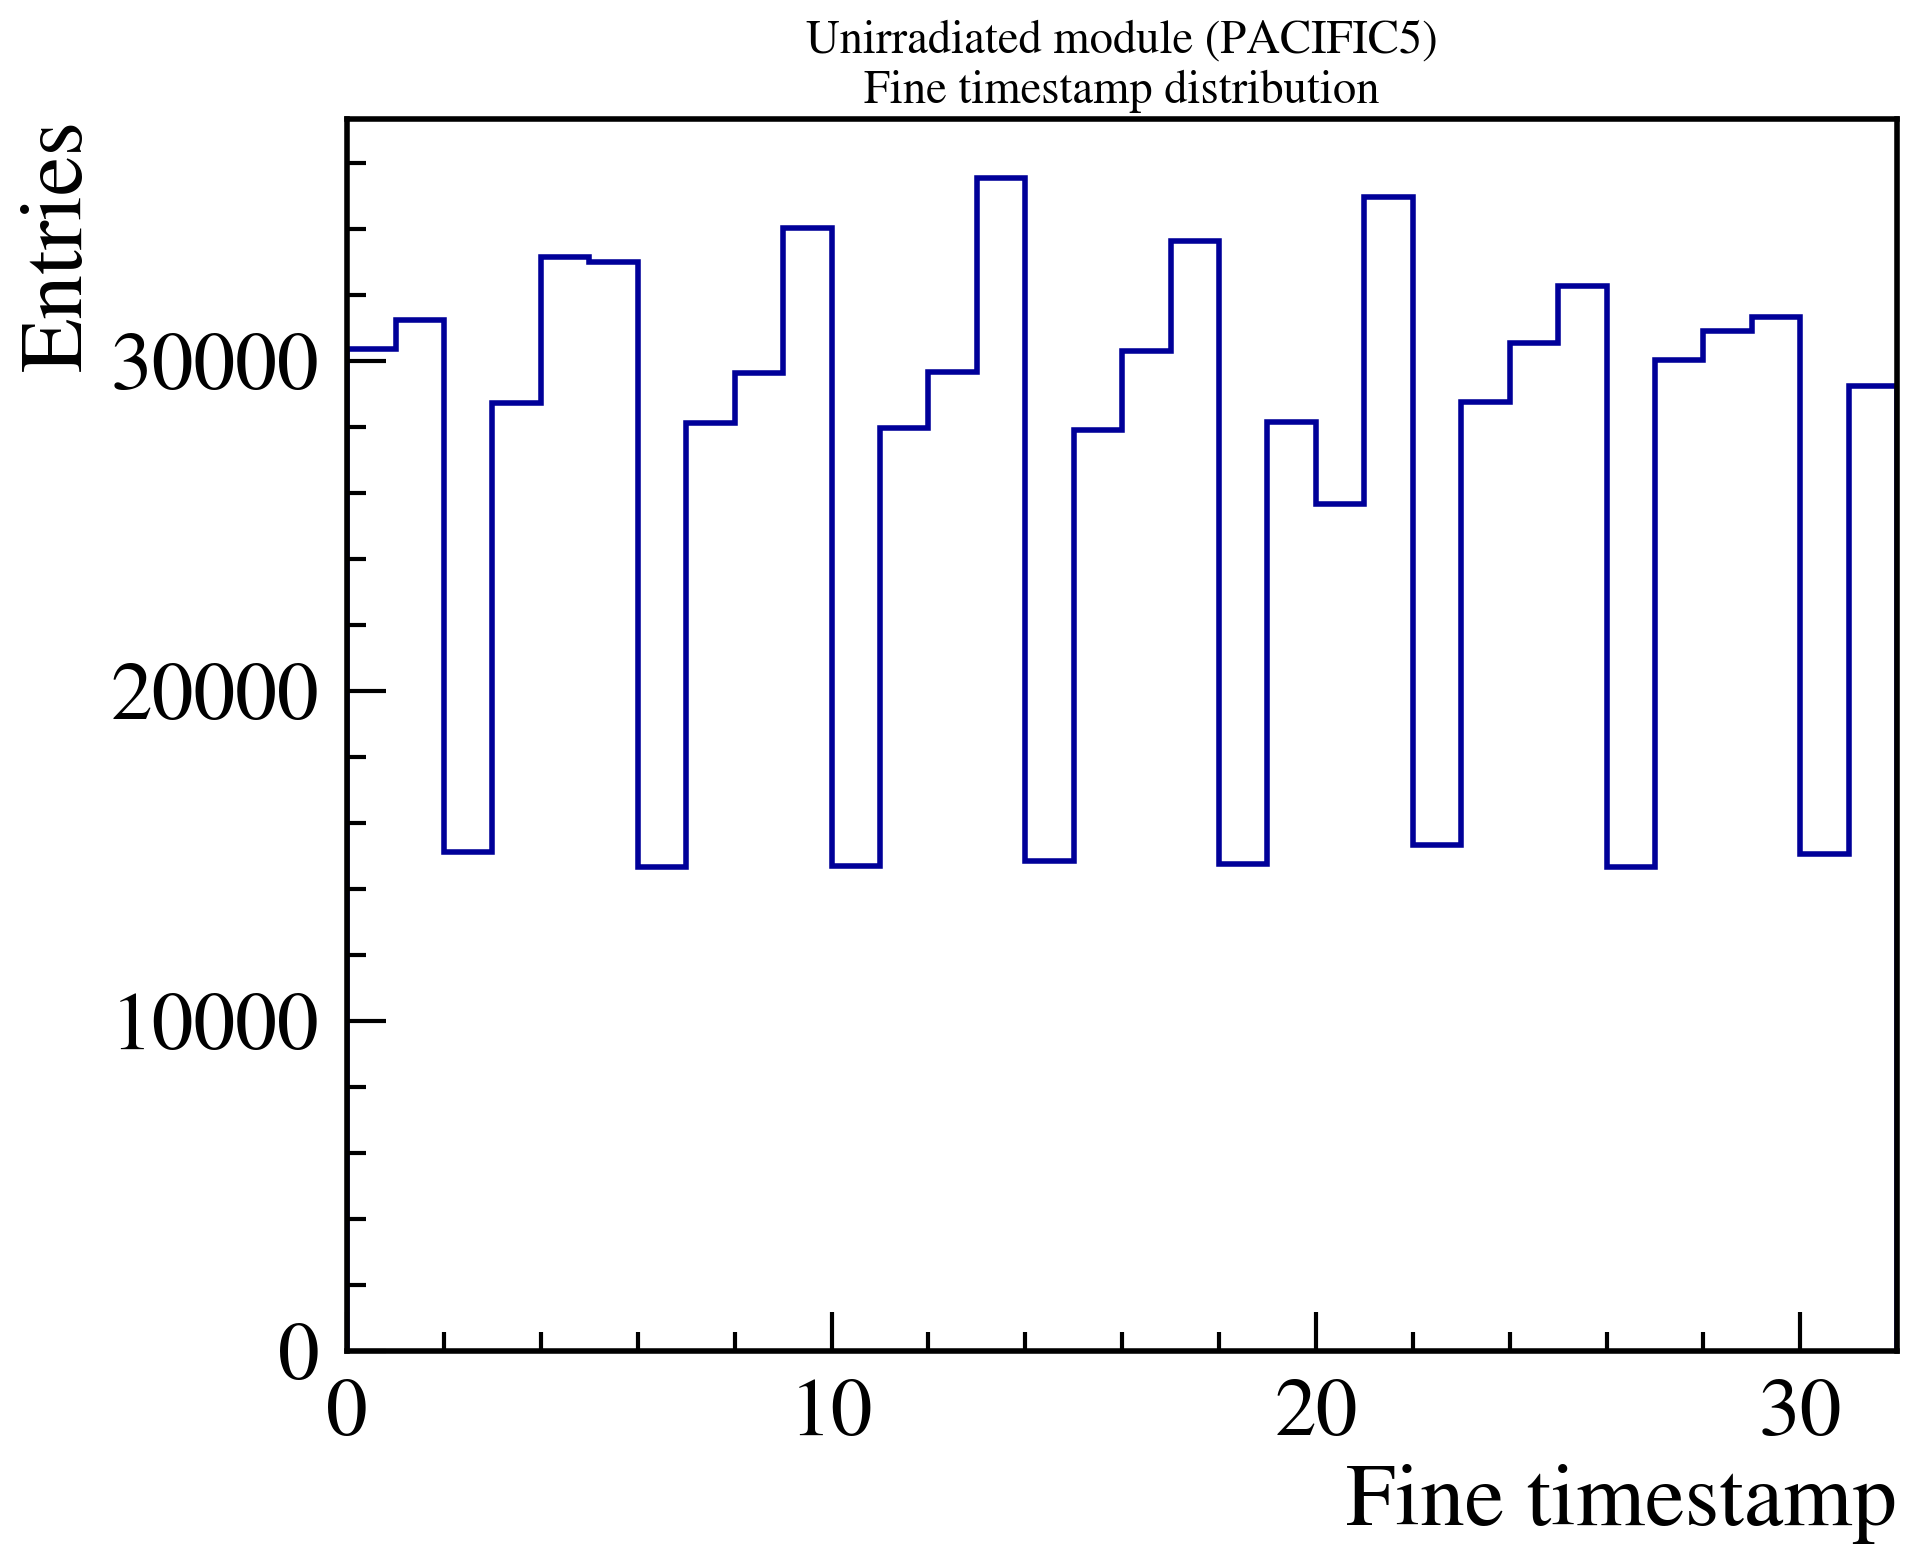

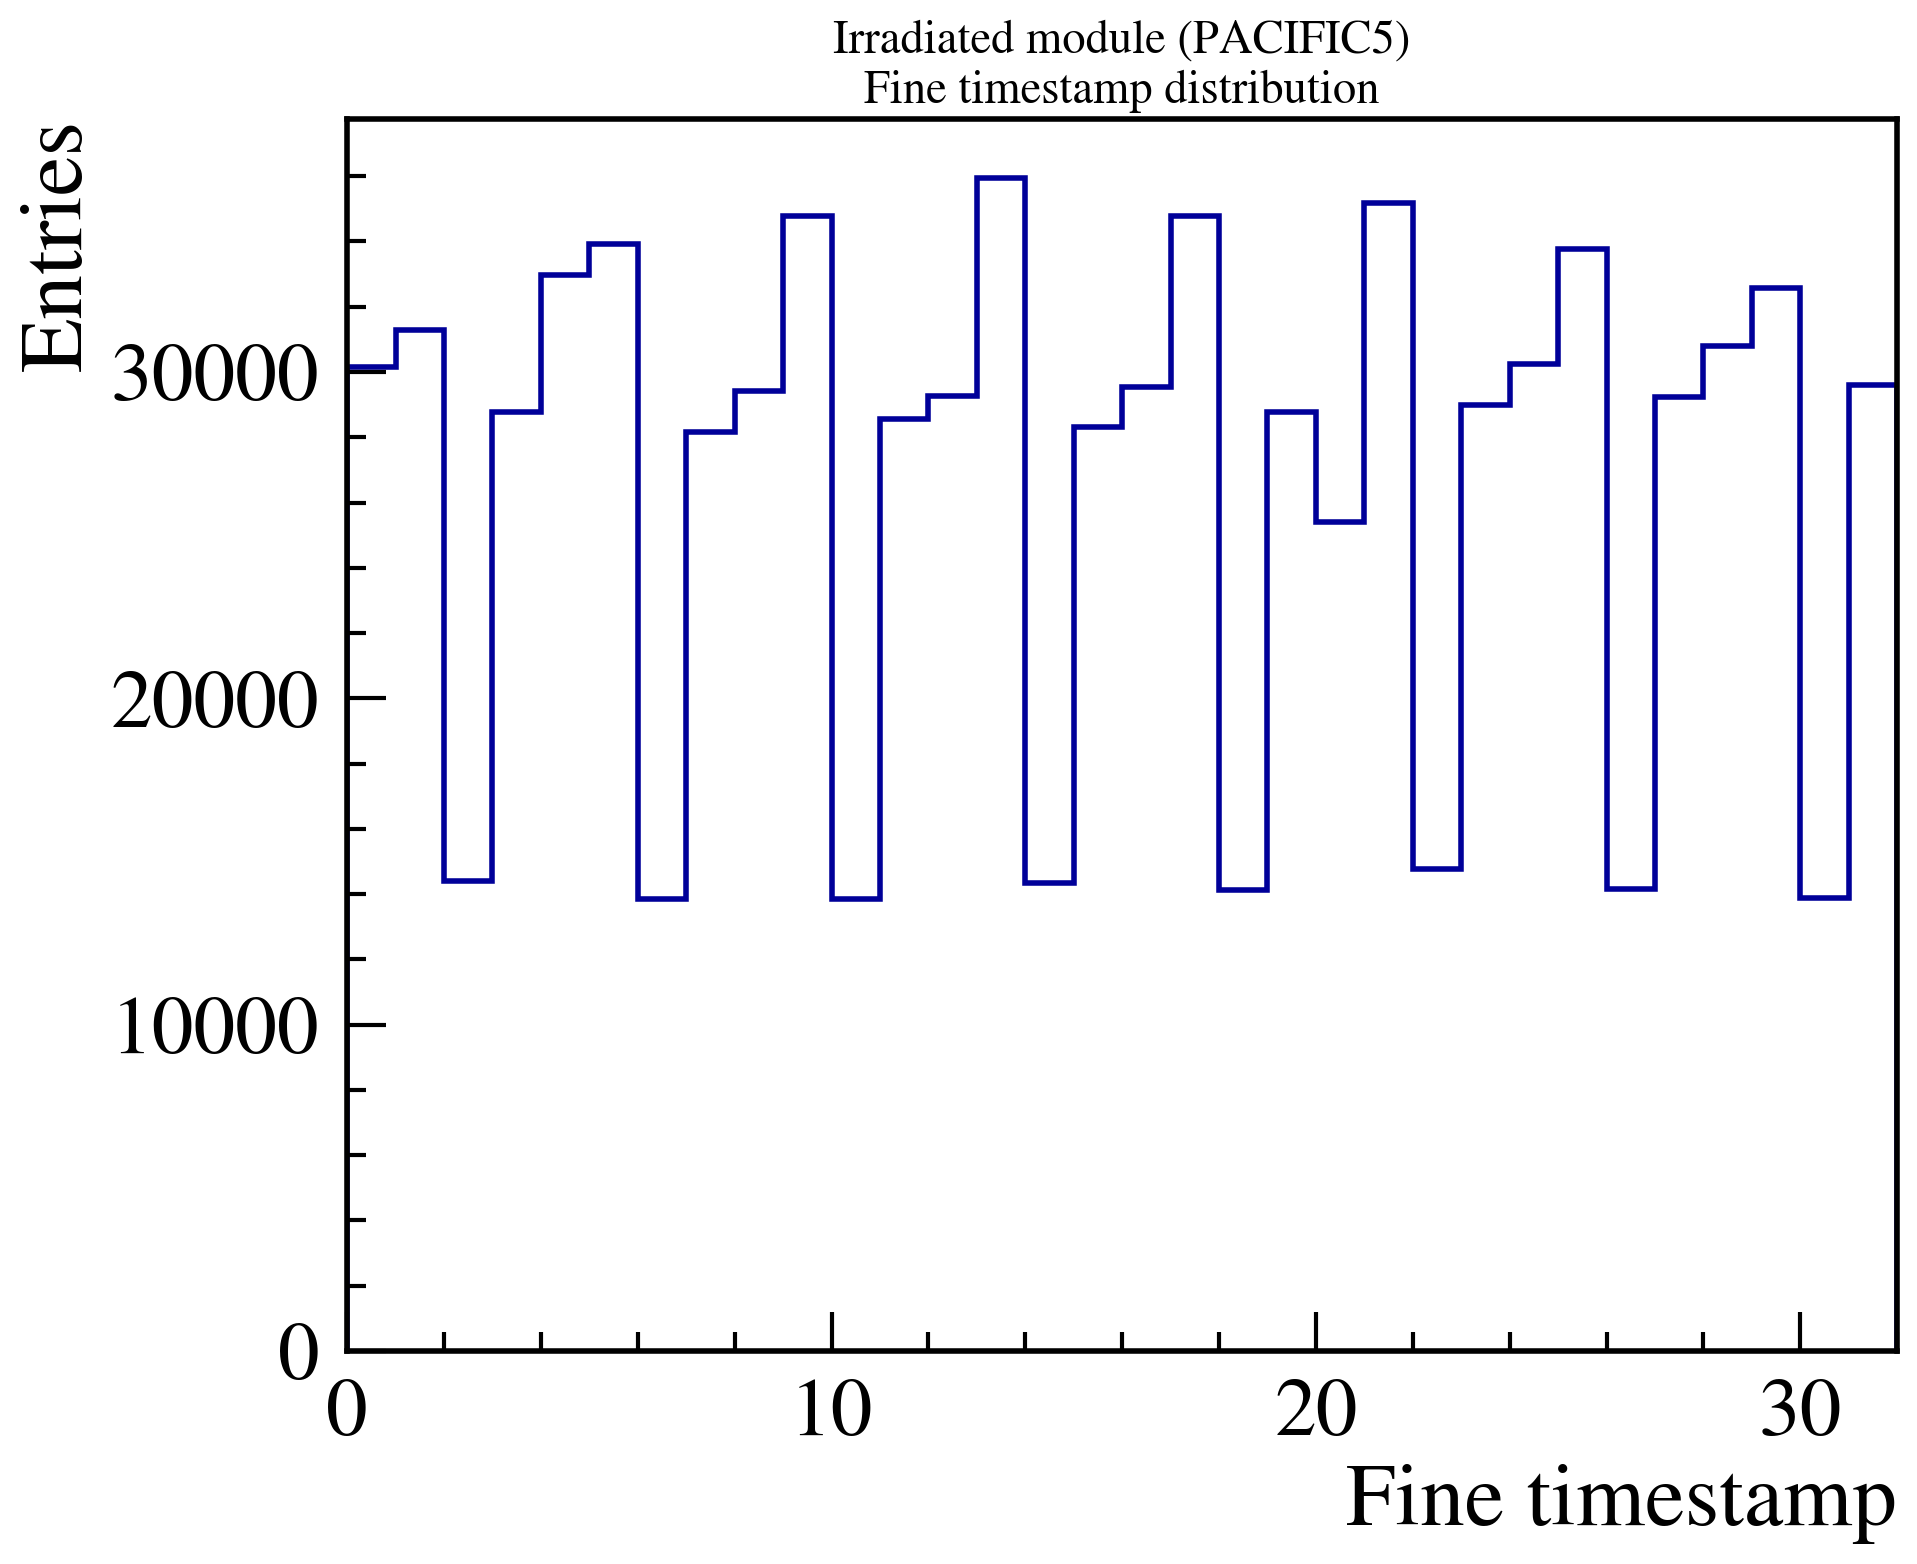

In [246]:
filename = "Plots/Testplots/Finetime_distribution.pdf" 
pp = PdfPages(filename)

for layer in [0,1]:
    DF = PACIFIC["Layer{}".format(layer)]
    DF_oneBX = DF[ DF["BXing"] == 0]
    finetimings = DF_oneBX["Finetiming"]
    dpl.hist(finetimings, bins=range(33))
    title = "Unirradiated module (PACIFIC5)" if layer == 0 else "Irradiated module (PACIFIC5)"
    title += "\nFine timestamp distribution"
    plt.title(title)
    
    plt.xlim(0,32)
    dpl.ylabel("Entries")
    dpl.xlabel("Fine timestamp")
    pp.savefig()
    plt.show()
    plt.close()

pp.close()

# PACIFIC Signalshape

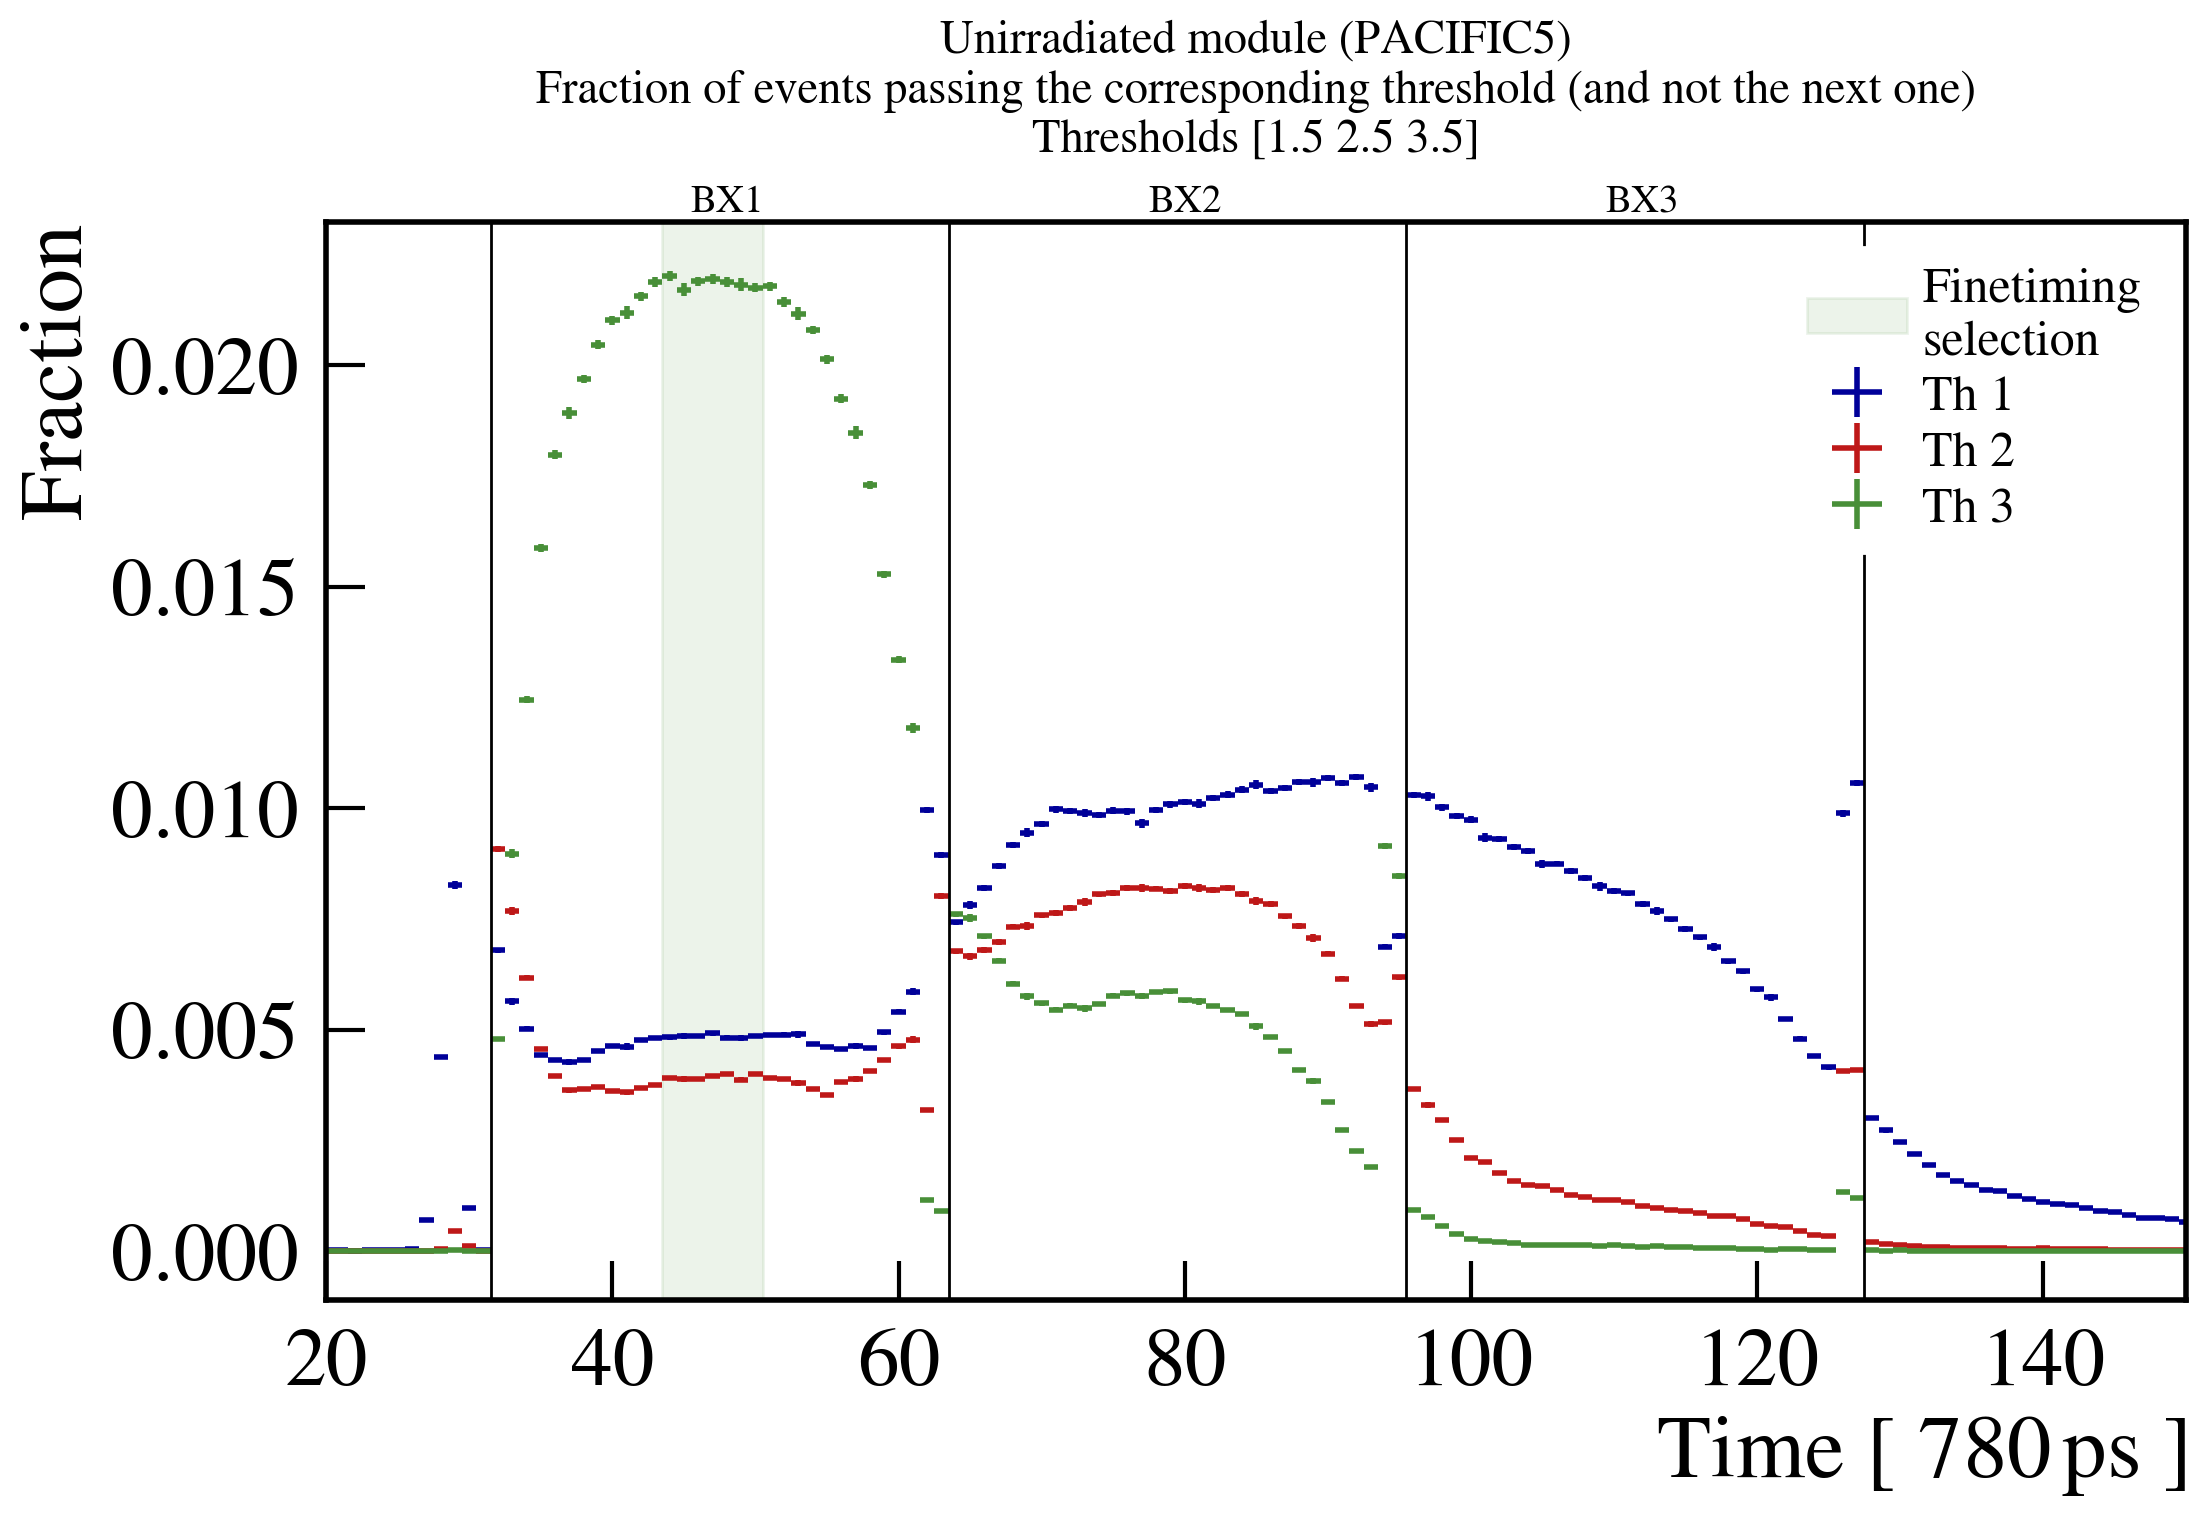

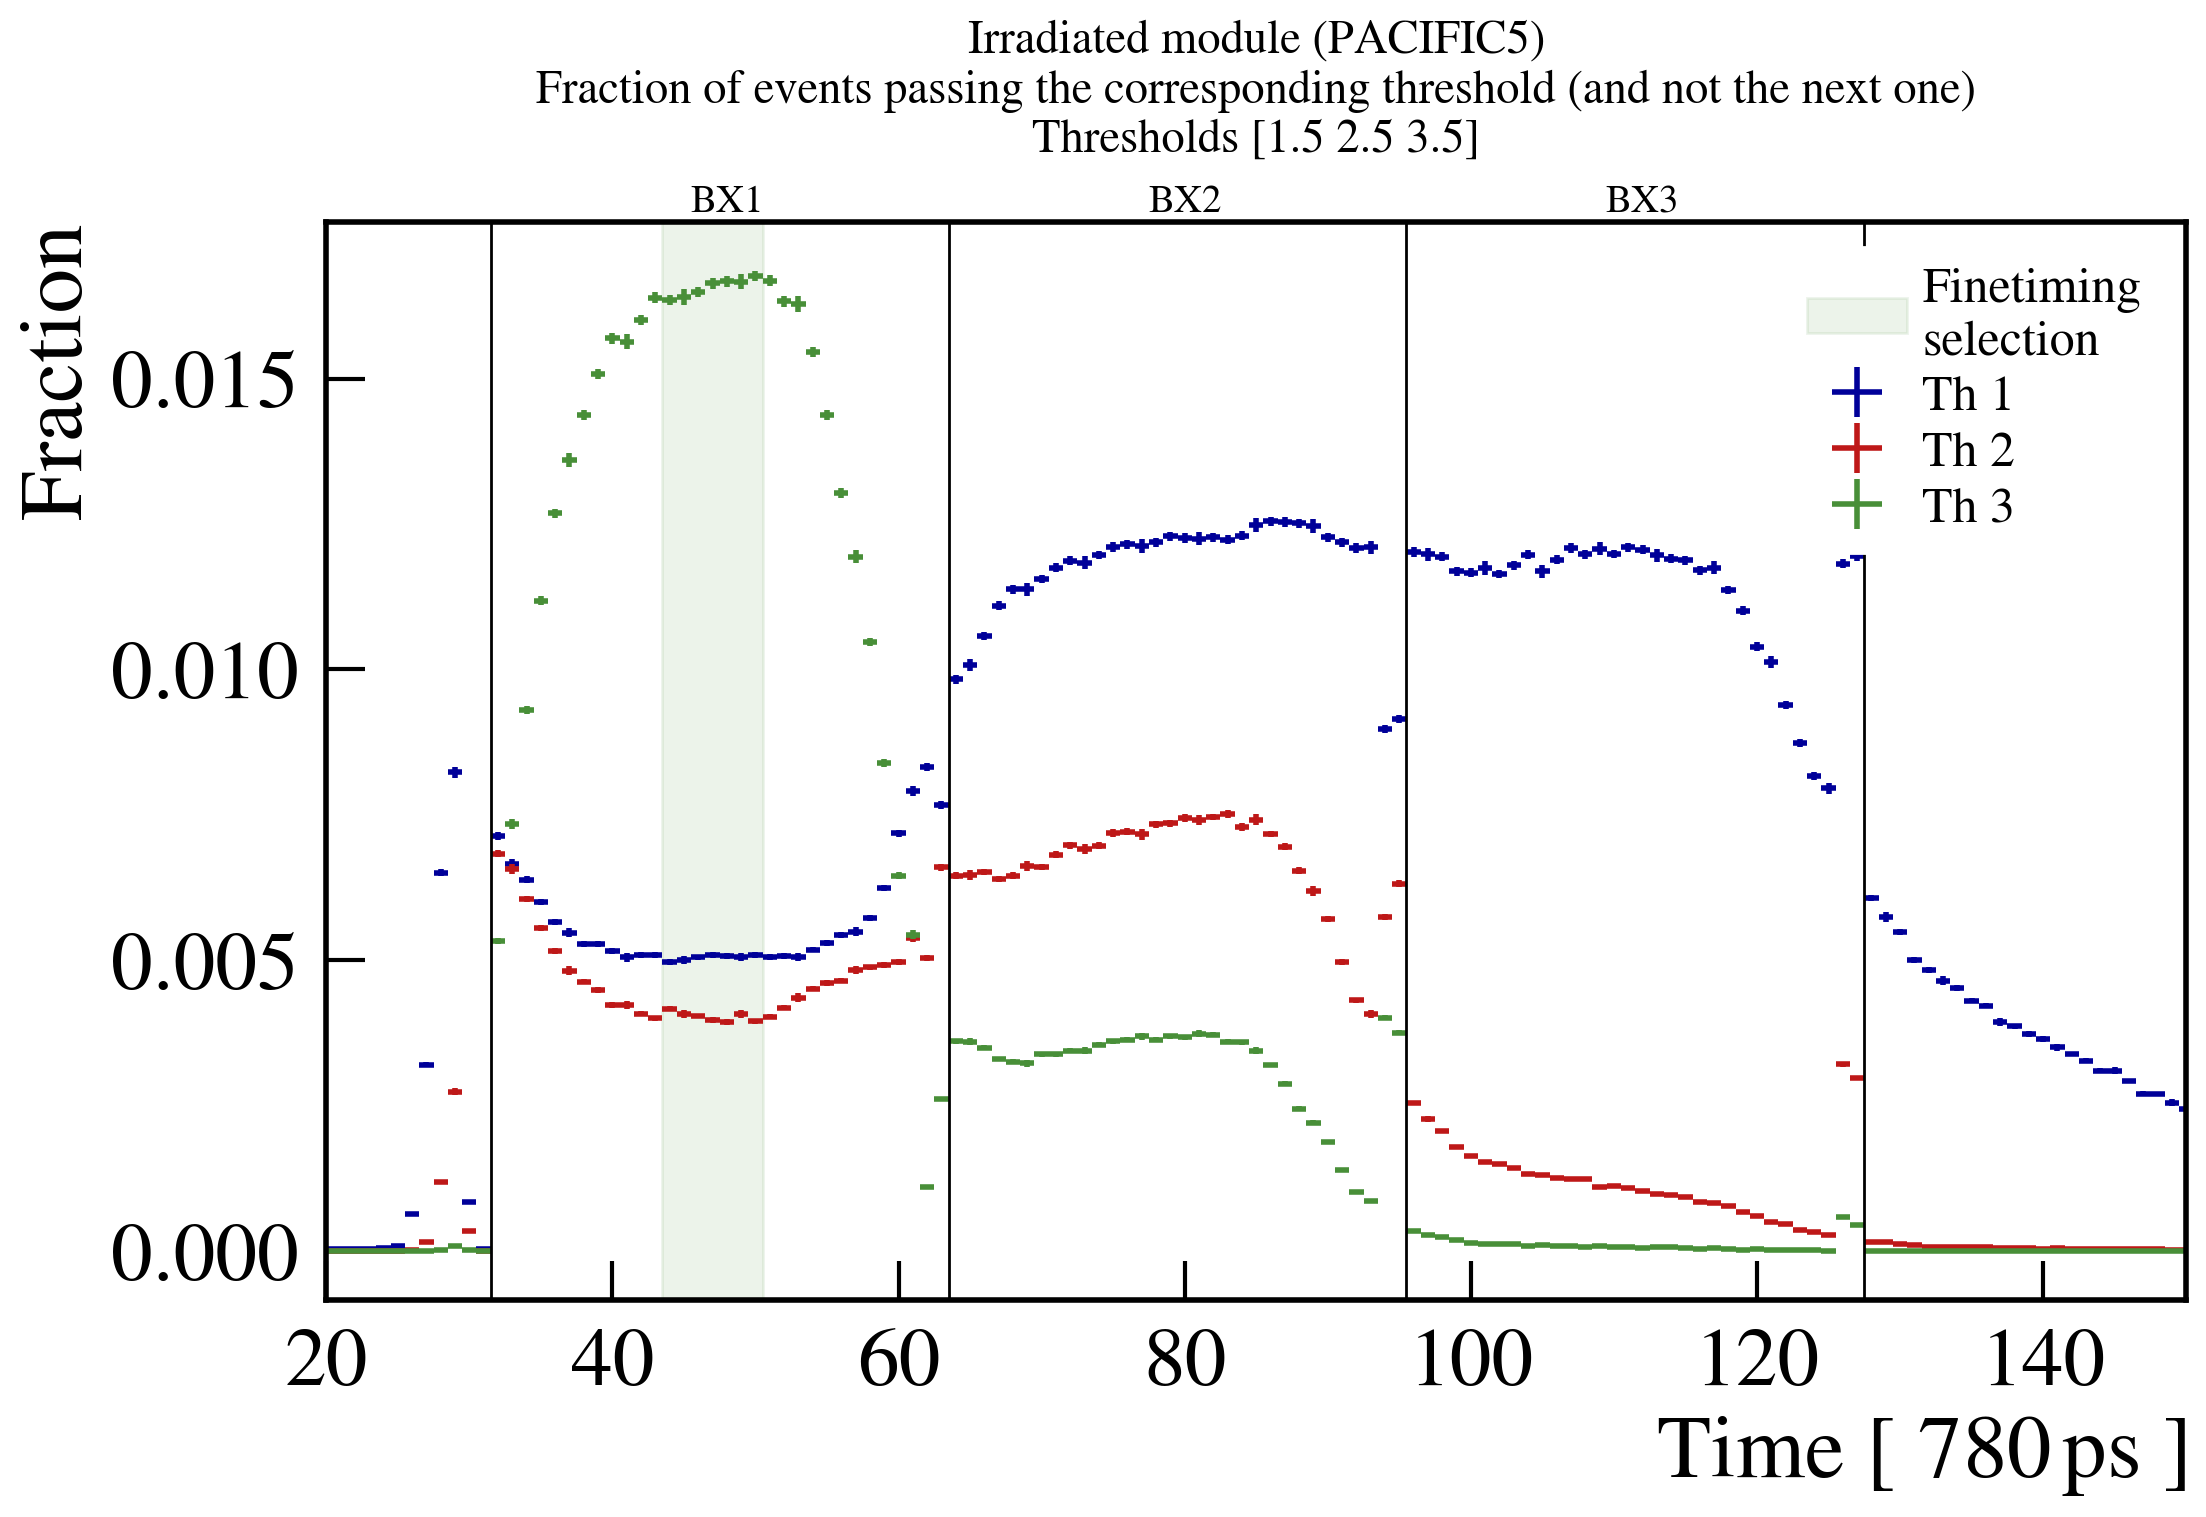

In [240]:
filename = "Plots/Testplots/Signalshape_allChs.pdf"
channels = range(64)

finetiming_selections = [ (13, 19, "gcgreen") ]

STUDENT.ensure_dir(os.path.dirname(filename))
pp = PdfPages(filename)

for layer in [0,1]:
    DF = PACIFIC["Layer{}".format(layer)]
    f, ax = plt.subplots(figsize=(12,7))
    #plt.axvspan(calc_time(1, 14), calc_time(1, 18), facecolor="gcorange", alpha=0.3, label="Selection")
    for Th in [1,2,3]:
        pacific_signal, time, errlow, errup = TB.signalshape(DF["BXing"], DF["Finetiming"], 
                                                             DF[["Ch_{}".format(ch) for ch in channels]].values, Th)
        ax.errorbar(np.asarray(time[:-1]), pacific_signal, xerr=0.5, yerr=[errlow,errup], fmt=".", ms=0, 
                     label="Th {}".format(Th))

    for finetiming_sel in finetiming_selections:
        time = ( TB.calc_time(1, finetiming_sel[0]-0.5), TB.calc_time(1, finetiming_sel[1]+0.5) )
        ax.axvspan(time[0], time[1], alpha=0.1, label="Finetiming\nselection",
                   color=finetiming_sel[2])

    plt.xlim(20,150)
    TB.plot_BX_overlay(ax)
    leg = ax.legend(fontsize=18, frameon=True, fancybox=False, facecolor="w", edgecolor="w", framealpha=1)



    dpl.xlabel(r'Time [ $780\,$ps ]')
    dpl.ylabel("Fraction")
    title = "Unirradiated module (PACIFIC5)" if layer == 0 else "Irradiated module (PACIFIC5)"
    title += "\nFraction of events passing the corresponding threshold (and not the next one)"
    title += "\nThresholds [{}]".format(PACIFIC_Thresholds)
    plt.title(title, y=1.05)
    pp.savefig()
    plt.show()
    plt.close()

pp.close()

# Pedestal subtraction and gain correction for SPIROC

In [247]:
def ped_gain_correction(chmatrix, layer):
    pedestal = SPIROC["Dark"]["Layer{}".format(layer)][ SPIROC_ch_range ].median(axis=0) 
    gain = 55.5 if layer == 0 else 53.5

    return (chmatrix - pedestal) / gain
    
    
#Correct SPIROC led data
SPIROC0_led_corr = ped_gain_correction(SPIROC["LED"]["Layer0"][SPIROC_ch_range], 0)
SPIROC1_led_corr = ped_gain_correction(SPIROC["LED"]["Layer1"][SPIROC_ch_range], 1)

#Correct SPIROC dataruns
SPIROC0_corr = ped_gain_correction(SPIROC["Particle"]["Layer0"][SPIROC_ch_range], 0)
SPIROC1_corr = ped_gain_correction(SPIROC["Particle"]["Layer1"][SPIROC_ch_range], 1)

# Plot SPIROC light spectrum

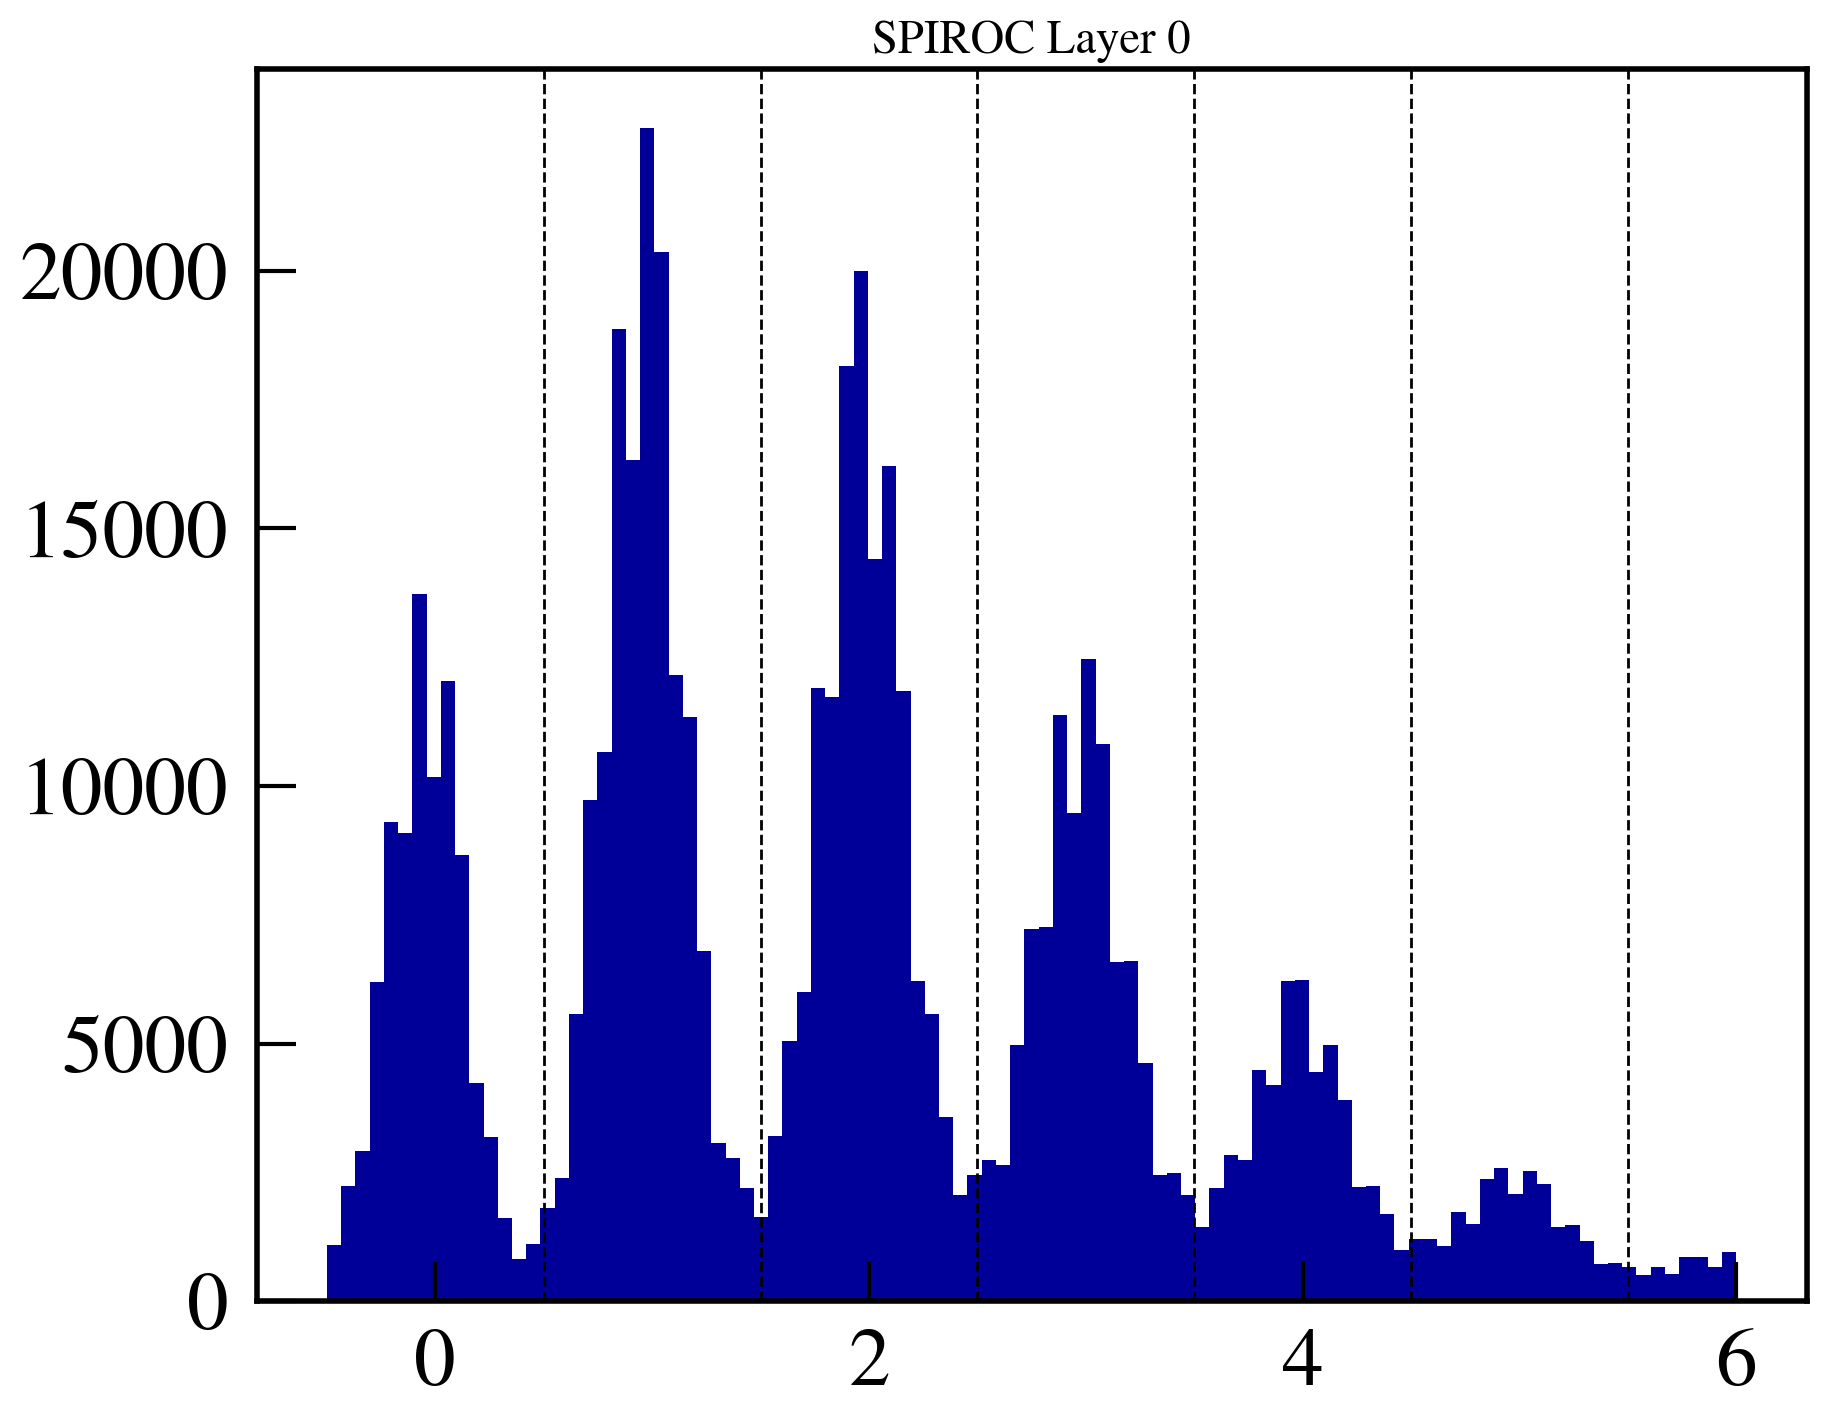

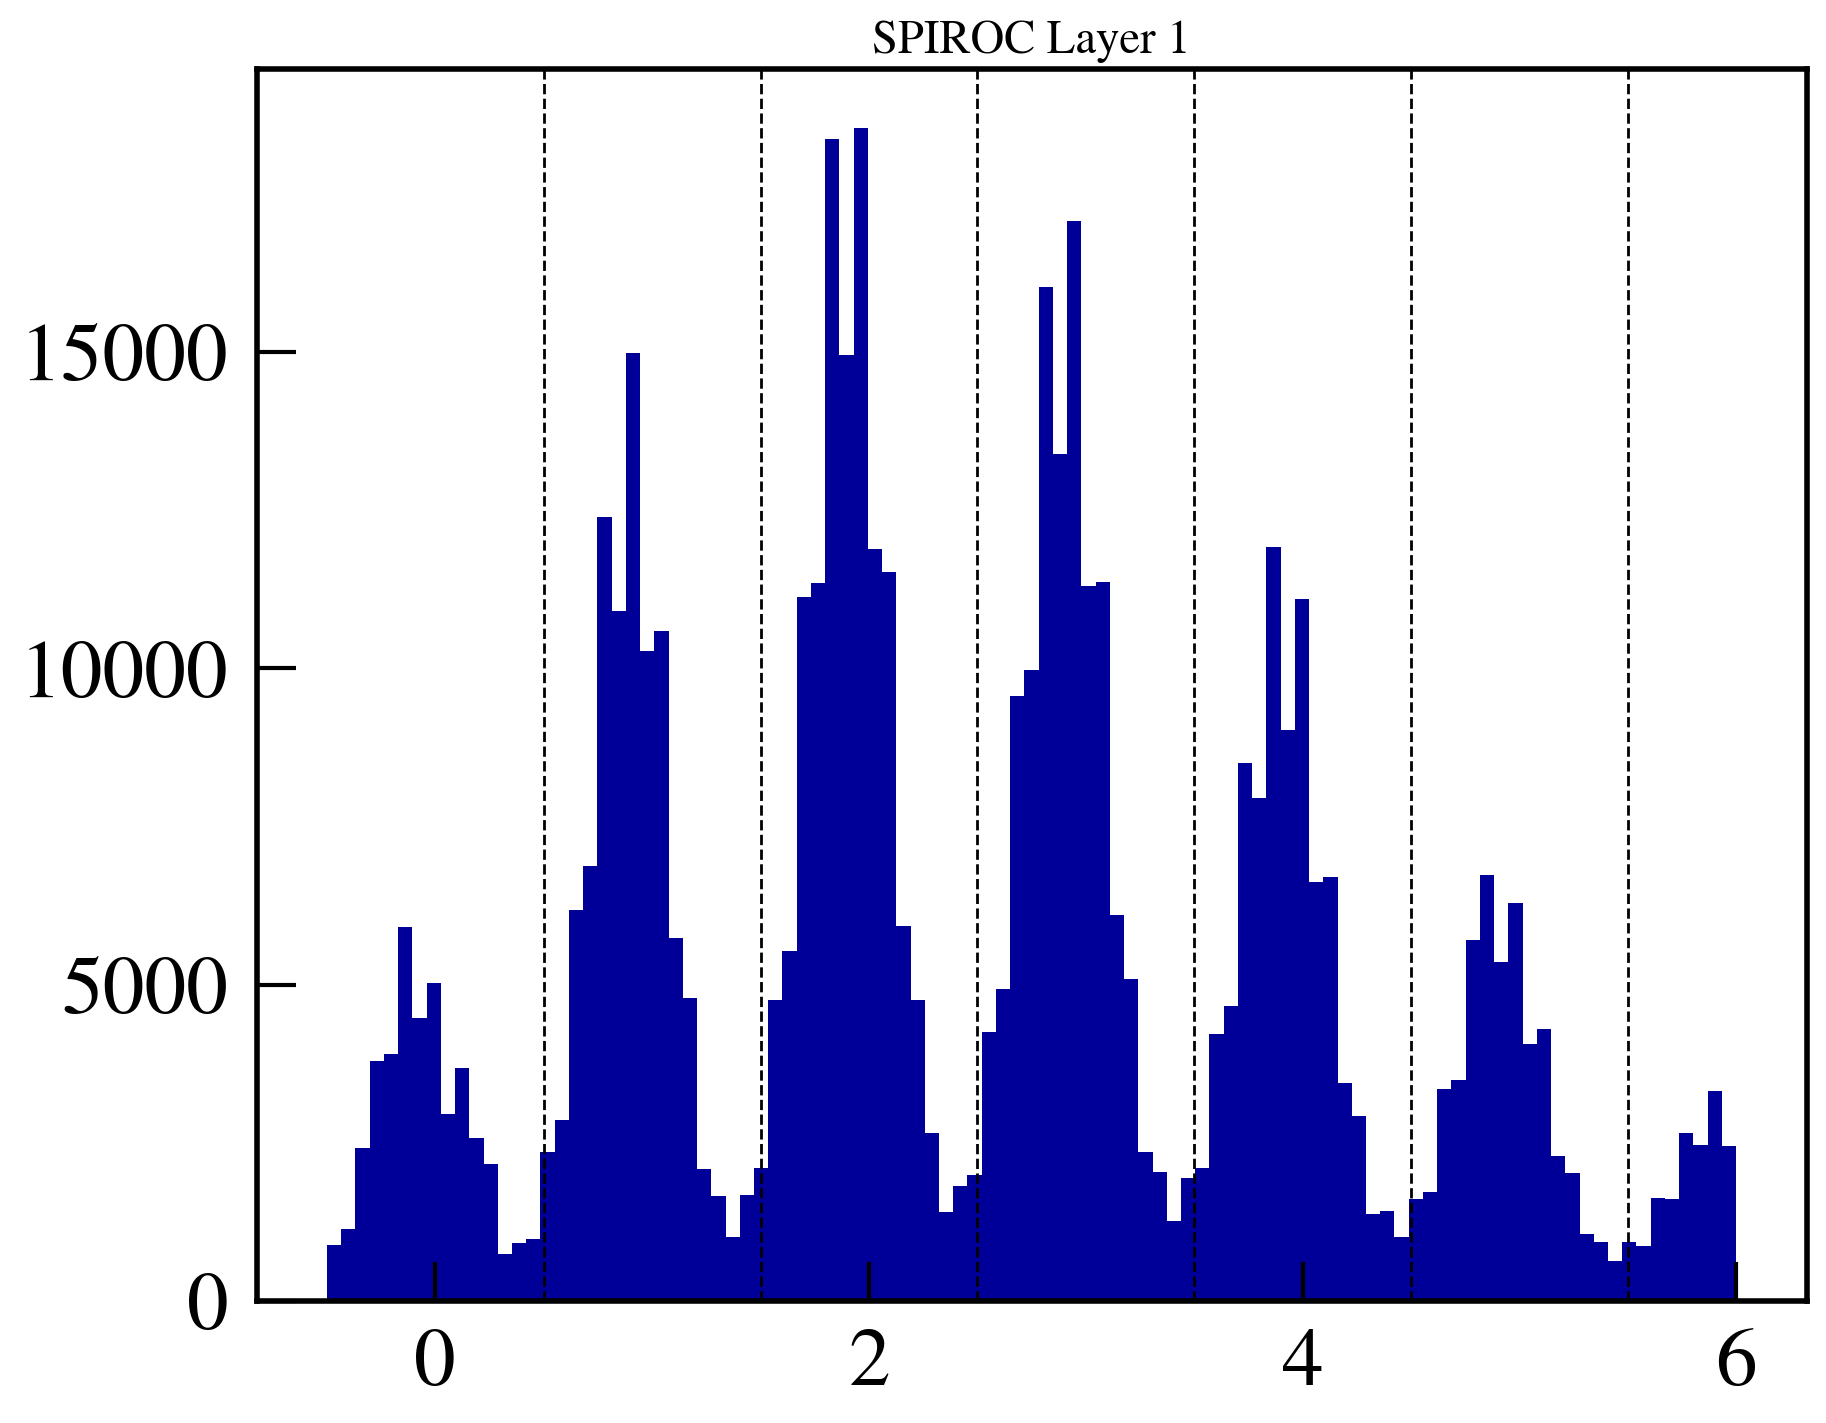

In [249]:
drift = -0.08  #Drifts in light injection runs
for layer, SPIROC_led_corr in enumerate([SPIROC0_led_corr, SPIROC1_led_corr]):
    plt.hist(SPIROC_led_corr.values.flatten()-drift, bins=np.linspace(-0.5, 6, 100))
    plt.title("SPIROC Layer {}".format(layer))
    for x in np.arange(0.5, 6, 1):
        plt.axvline(x, color="k", ls="--", lw=1)
    plt.show()
    plt.close()

# Plot SPIROC datarun spectrum

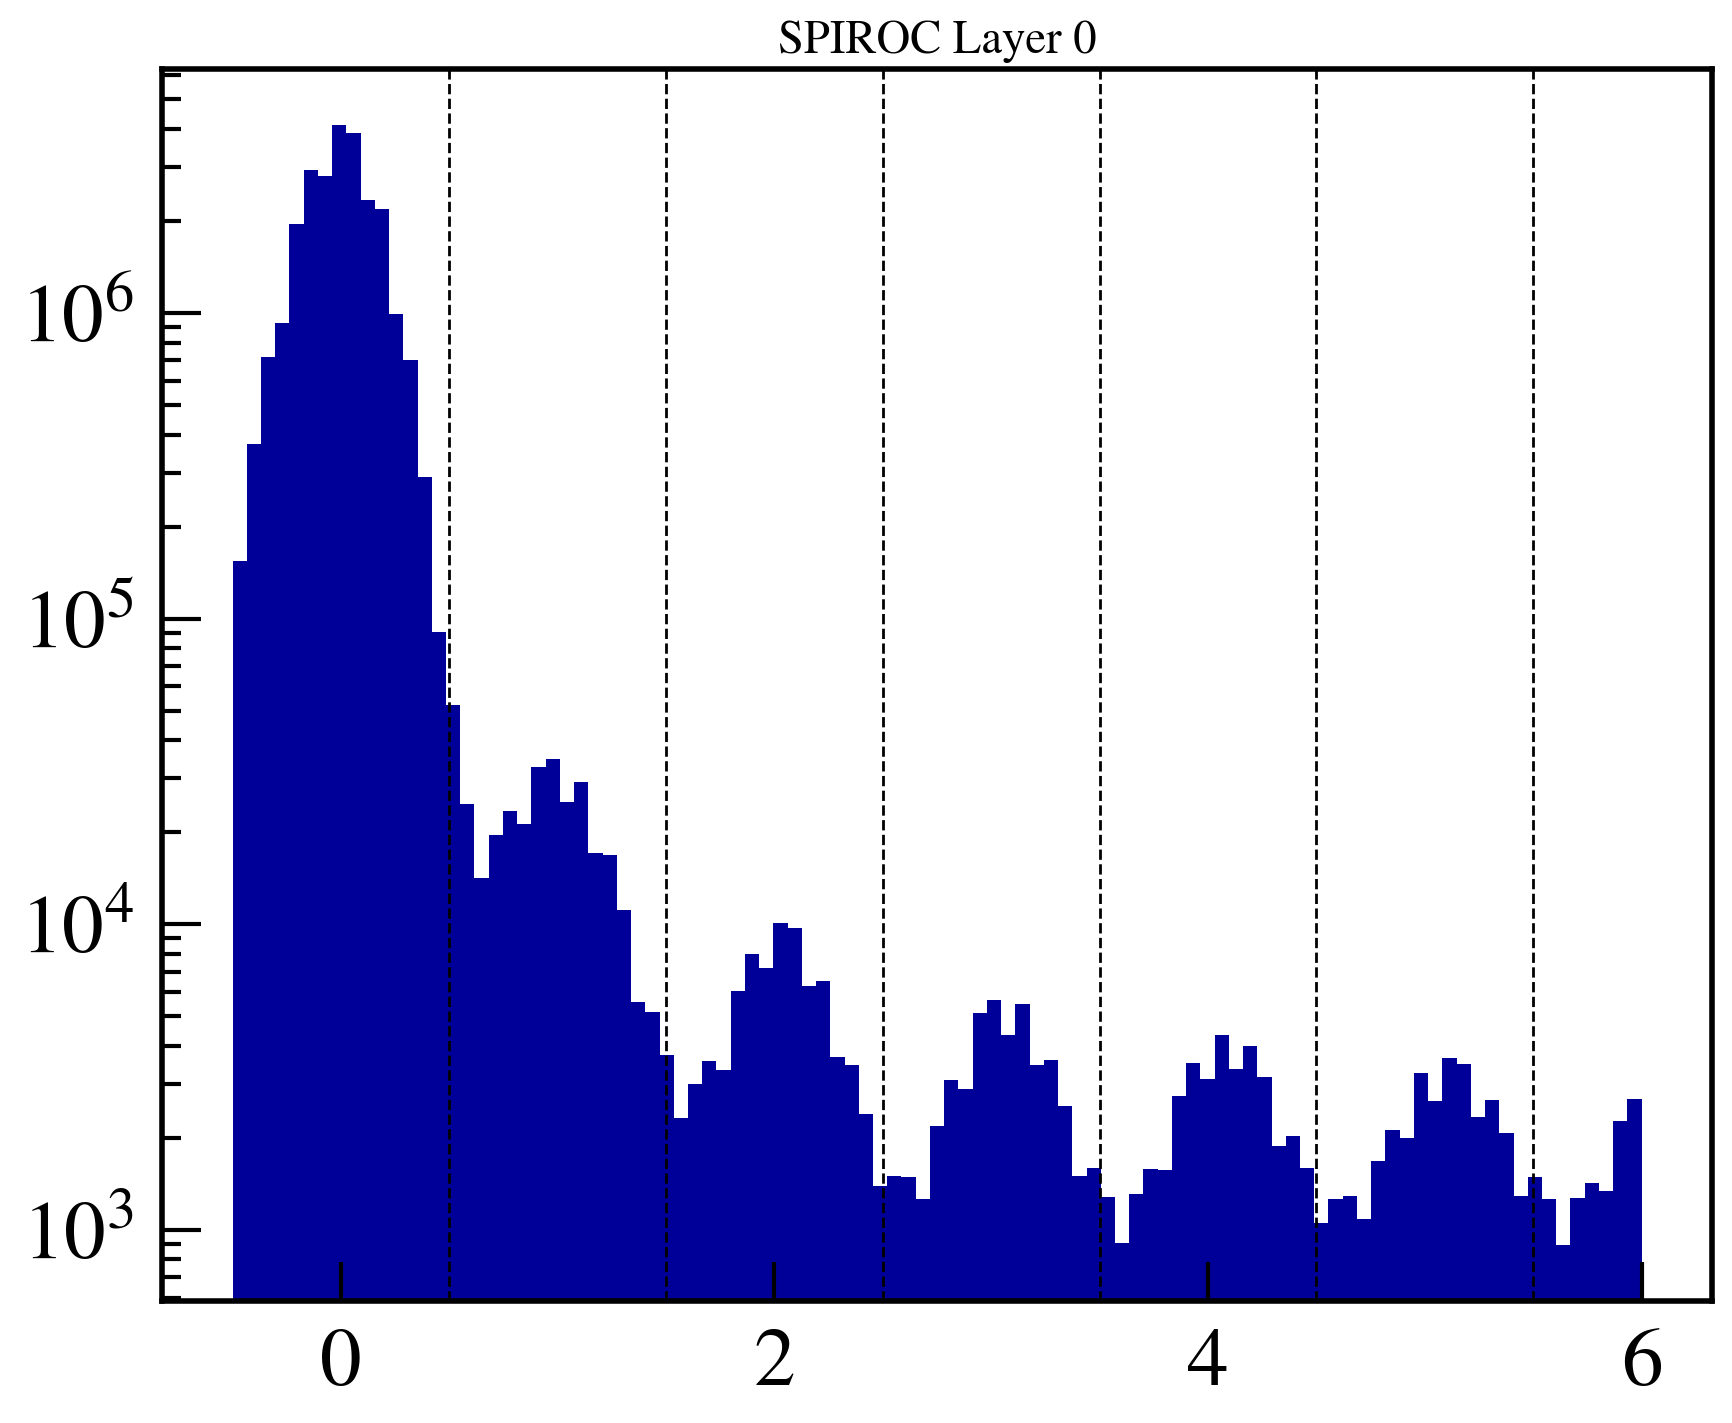

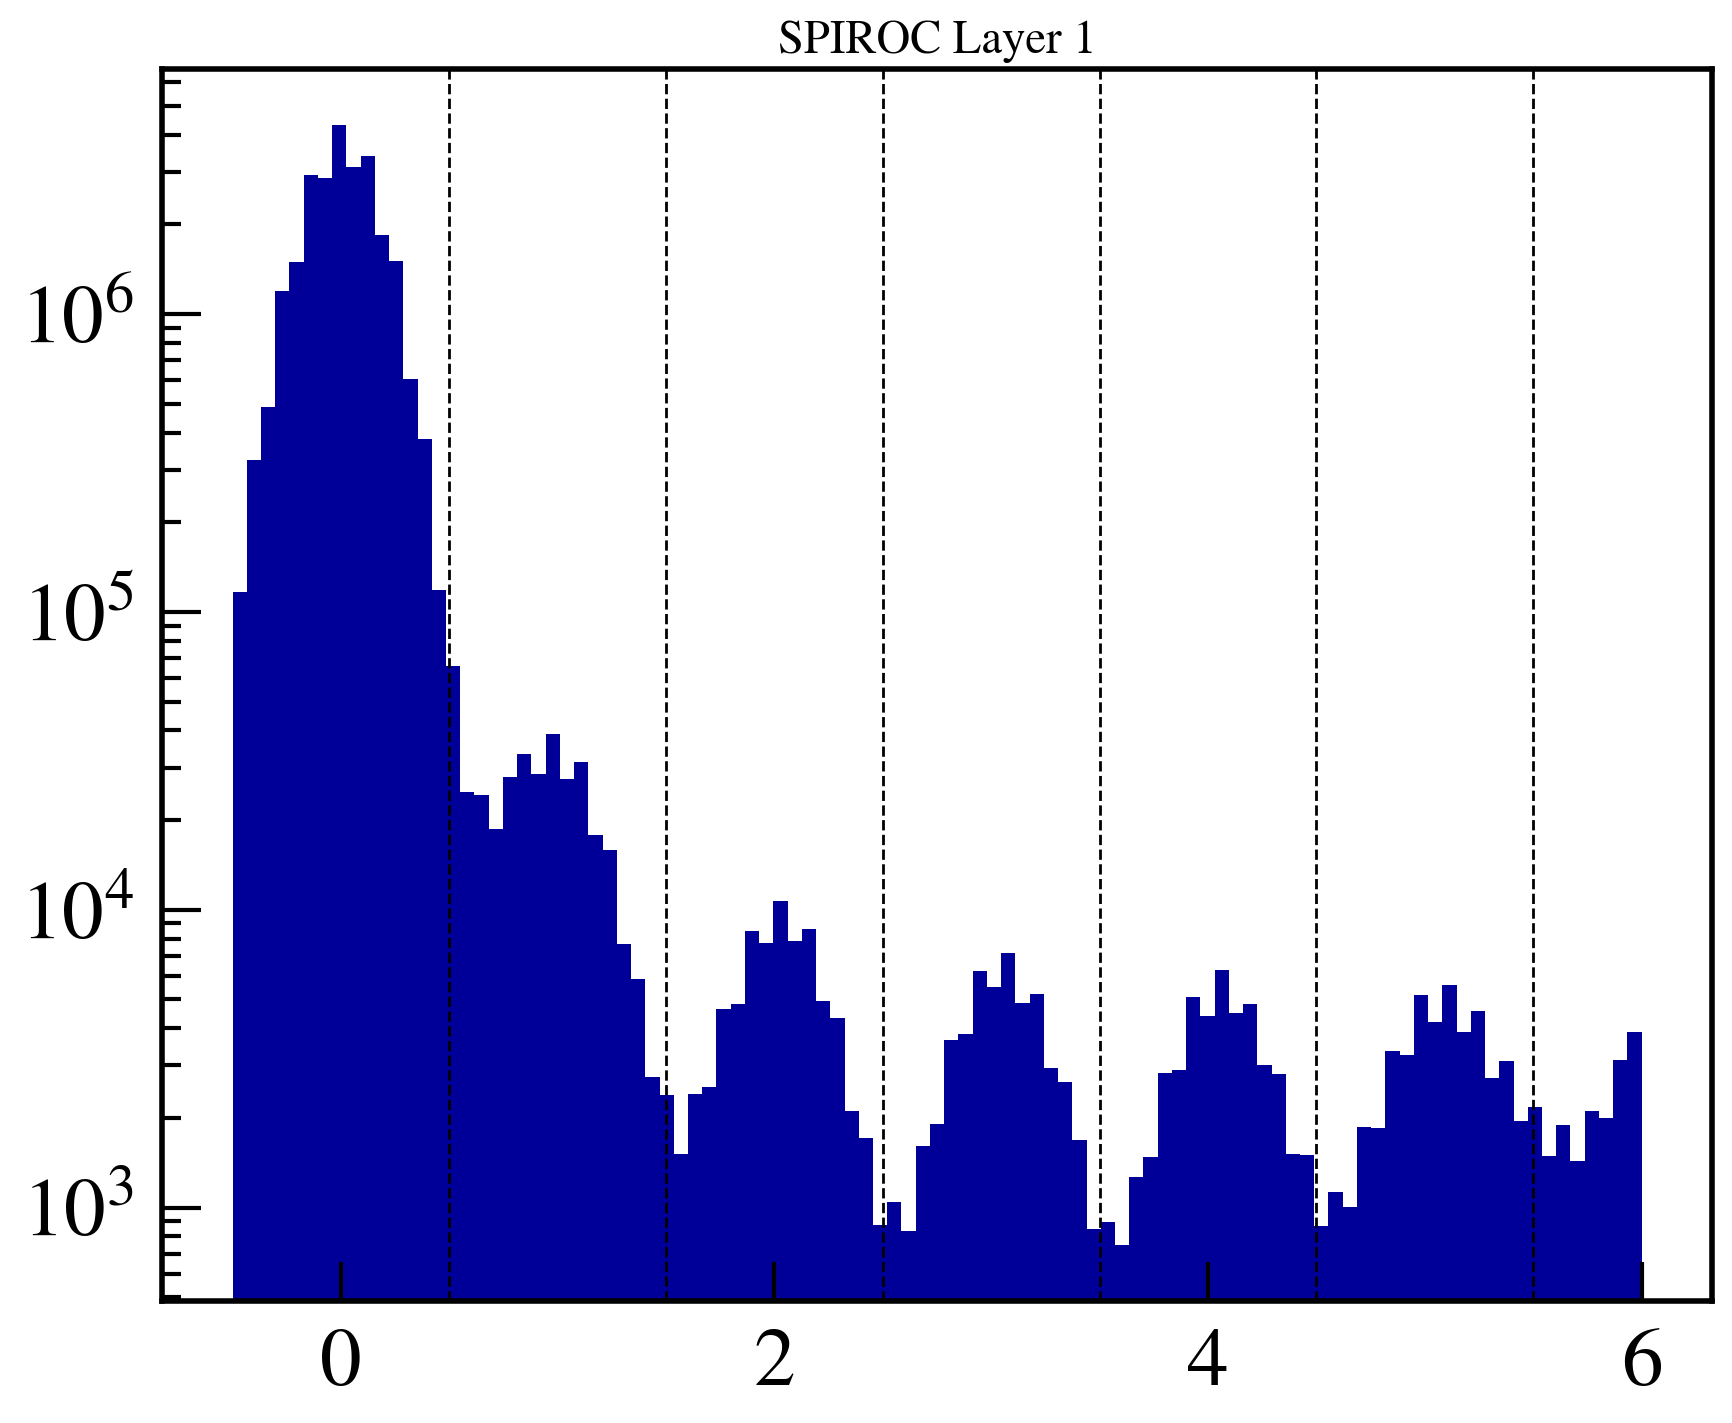

In [259]:
for layer, SPIROC_corr in enumerate([SPIROC0_corr, SPIROC1_corr]):
    plt.hist(SPIROC_corr.values.flatten(), bins=np.linspace(-0.5, 6, 100), log=True)
    plt.title("SPIROC Layer {}".format(layer))
    for x in np.arange(0.5, 6, 1):
        plt.axvline(x, color="k", ls="--", lw=1)
    plt.show()
    plt.close()

# With pre-done calibration (by Roman)

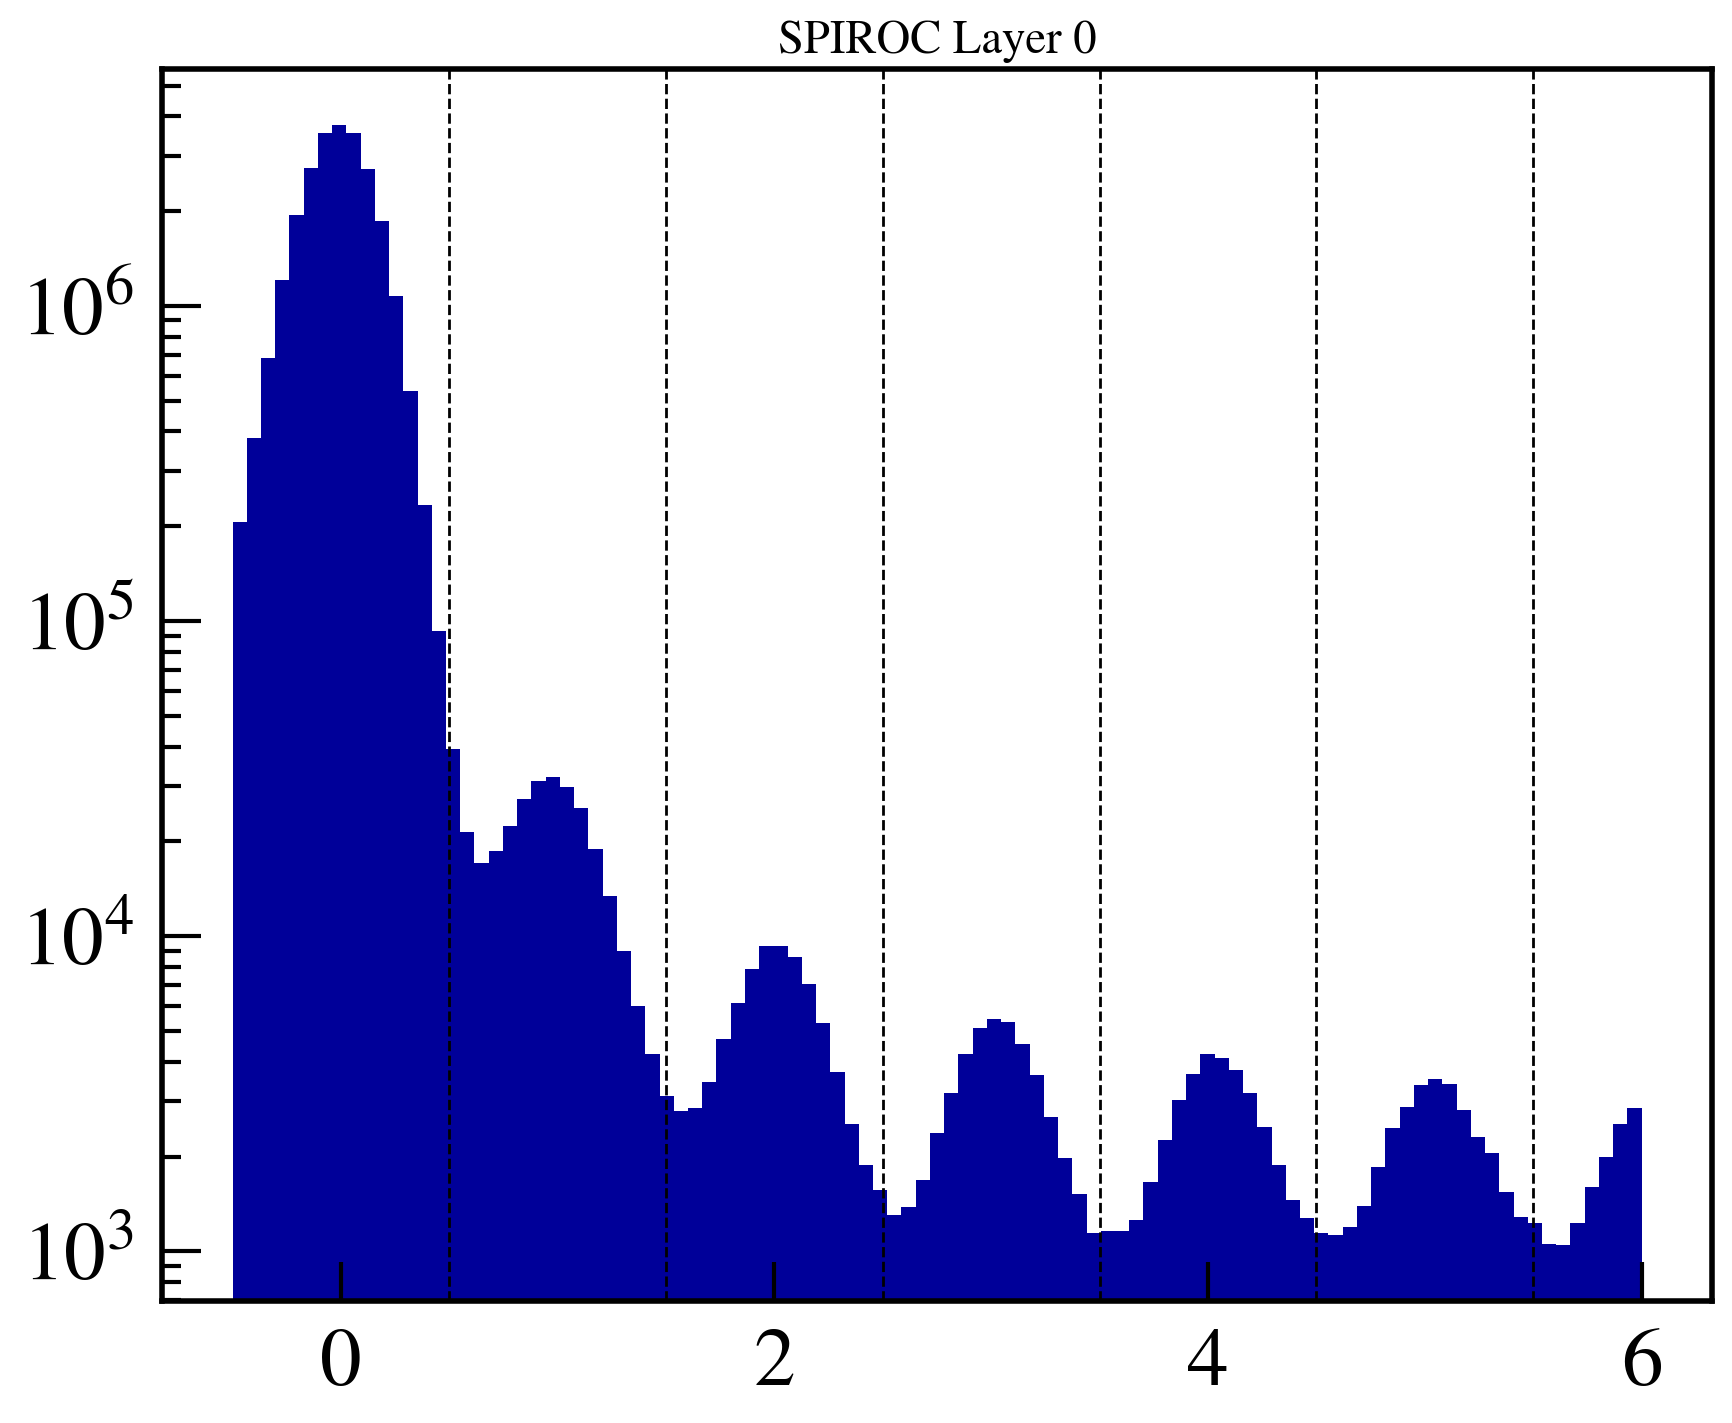

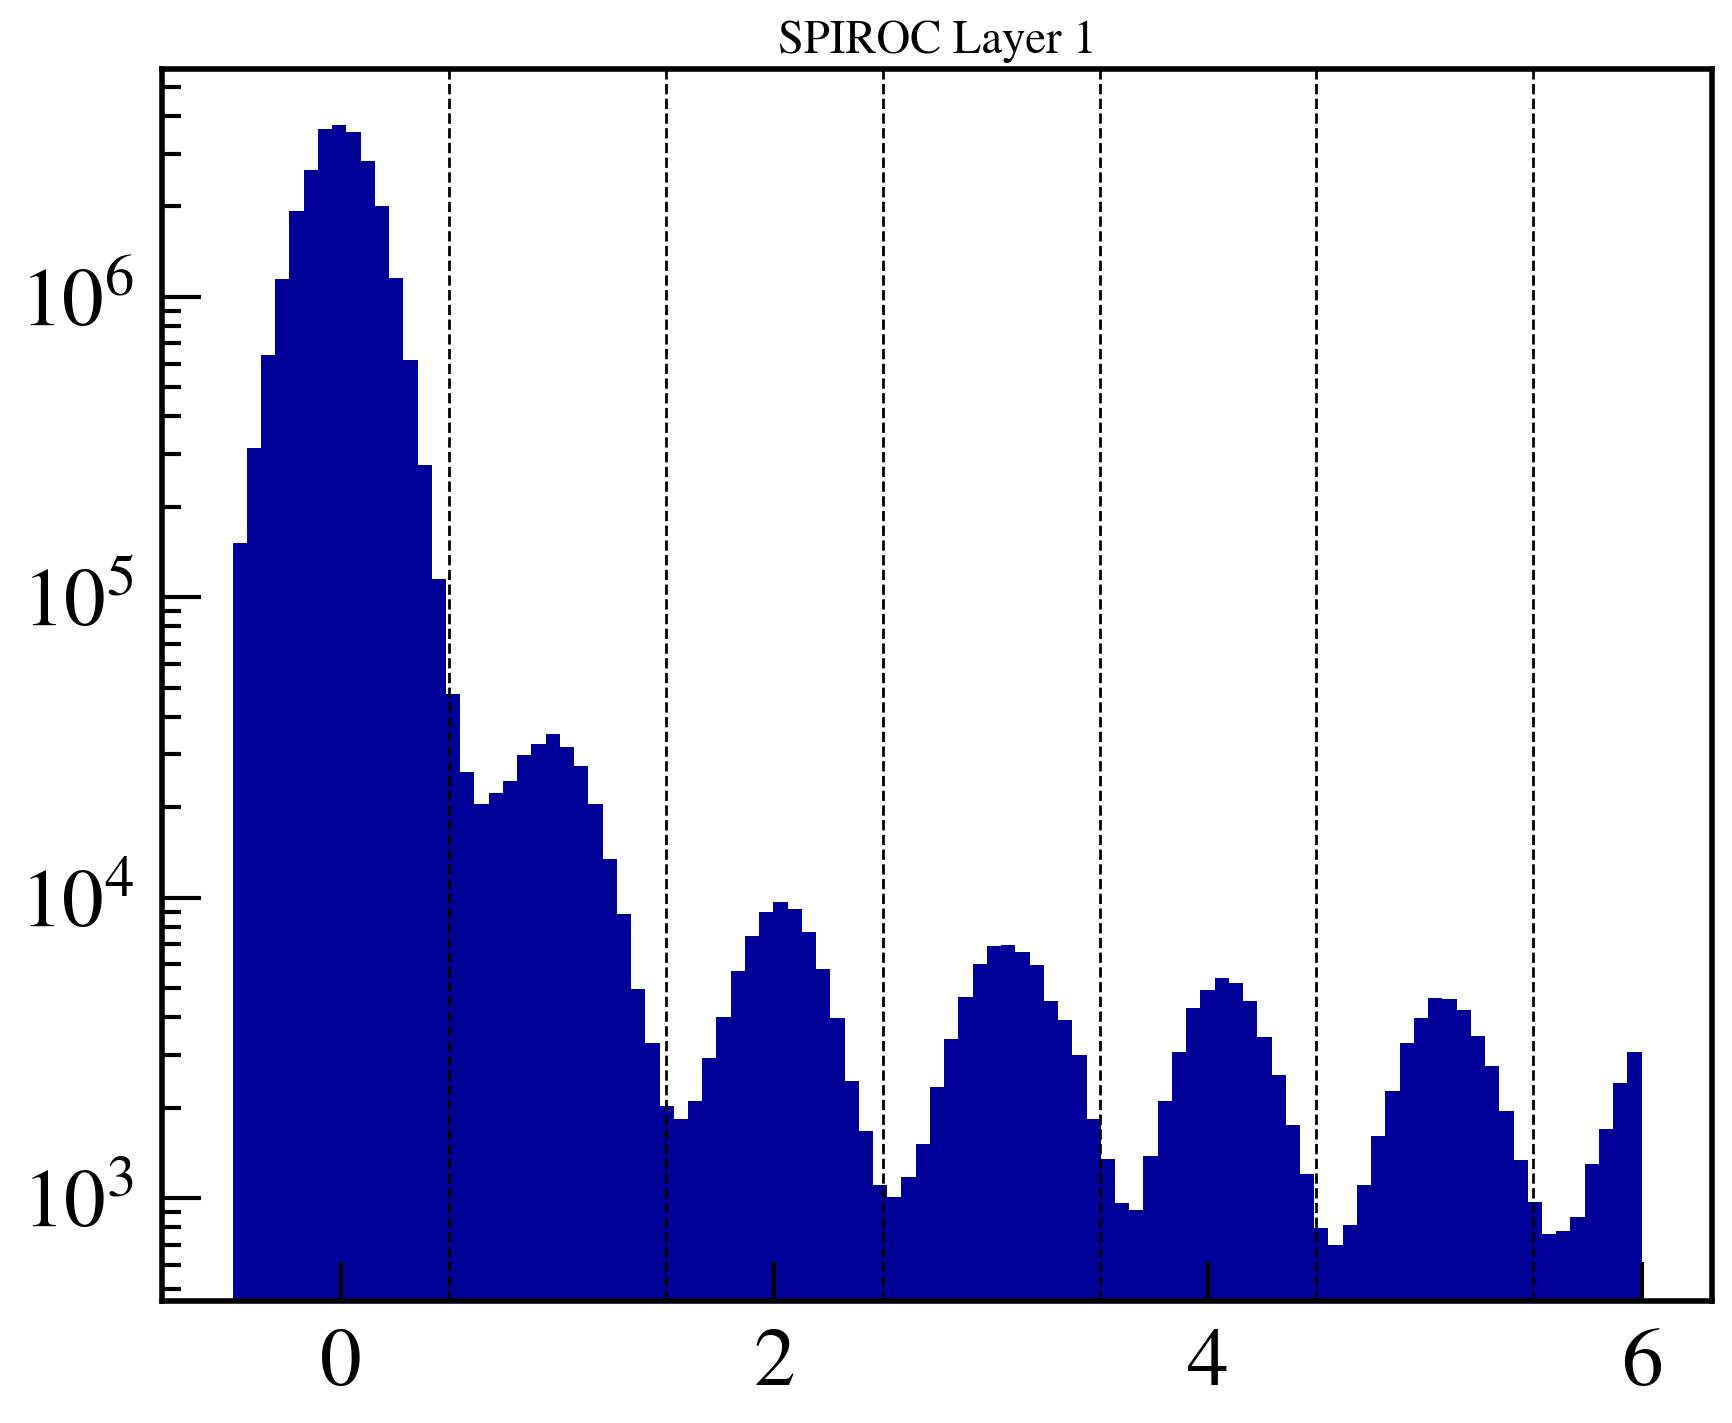

In [260]:
for layer, SPIROC_corr in enumerate([SPIROC["Particle"]["Layer0"][SPIROC_ch_range_calib], 
                                SPIROC["Particle"]["Layer1"][SPIROC_ch_range_calib]]):
    plt.hist(SPIROC_corr.values.flatten(), bins=np.linspace(-0.5, 6, 100), log=True)
    plt.title("SPIROC Layer {}".format(layer))
    for x in np.arange(0.5, 6, 1):
        plt.axvline(x, color="k", ls="--", lw=1)
    plt.show()
    plt.close()

# PACIFIC Finetiming selection

In [100]:
PACIFIC_sel0 = PACIFIC["Layer0"].query("Finetiming >= 13 and Finetiming <= 19 and BXing == 1")
evts_before = len(PACIFIC["Layer0"])
evts_after = len(PACIFIC_sel0)
print("Layer0: {} events out of {} survive selection ({:.2%})".format(evts_after, evts_before, evts_after/evts_before))

PACIFIC_sel1 = PACIFIC["Layer1"].query("Finetiming >= 13 and Finetiming <= 19 and BXing == 1")
evts_before = len(PACIFIC["Layer1"])
evts_after = len(PACIFIC_sel1)
print("Layer1: {} events out of {} survive selection ({:.2%})".format(evts_after, evts_before, evts_after/evts_before))

Layer0: 185176 events out of 6834967 survive selection (2.71%)
Layer1: 185832 events out of 6831047 survive selection (2.72%)


# PACIFIC Ratio plots

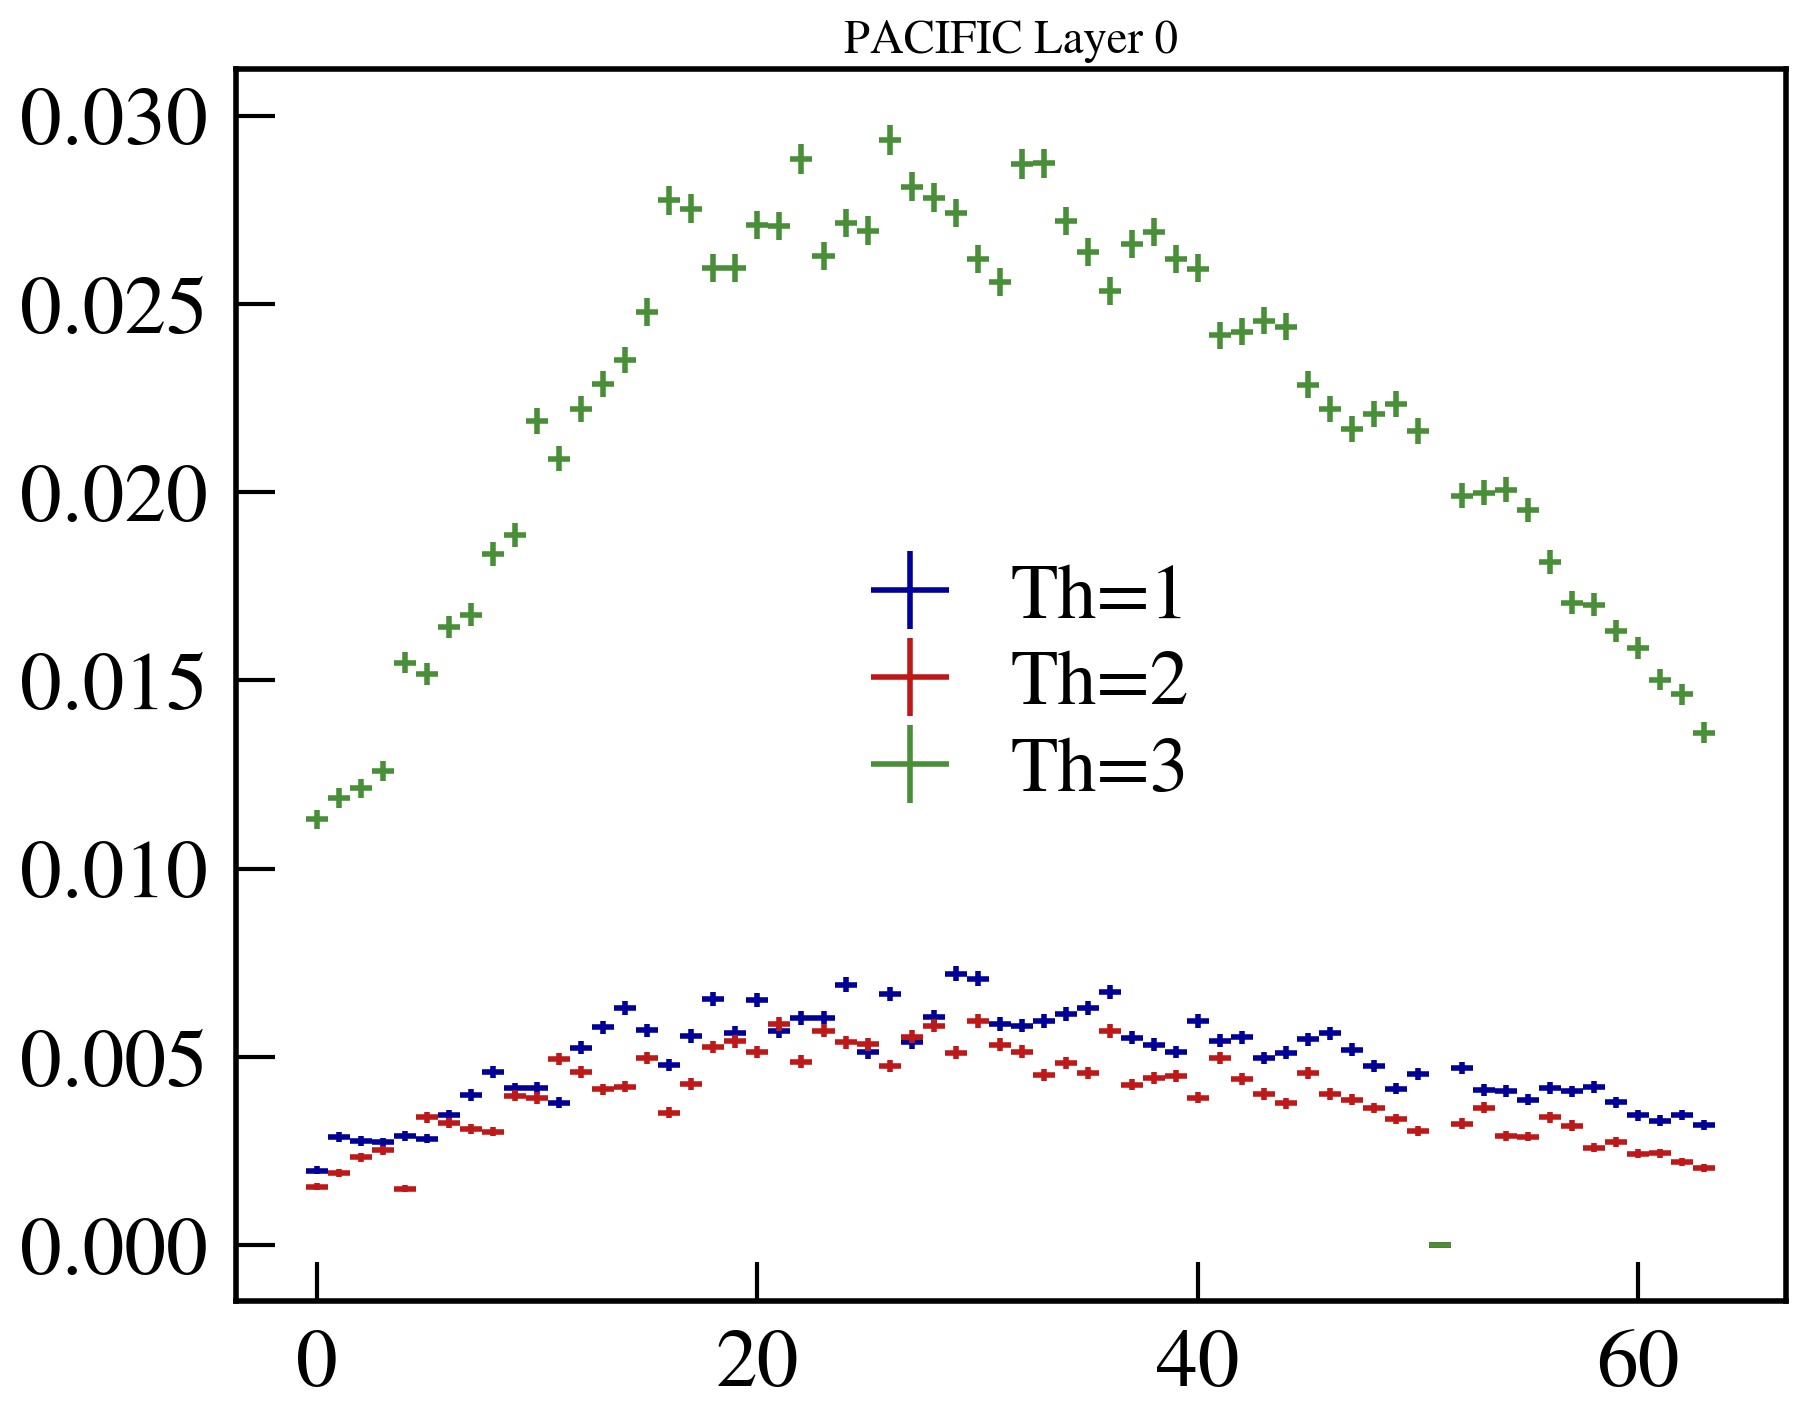

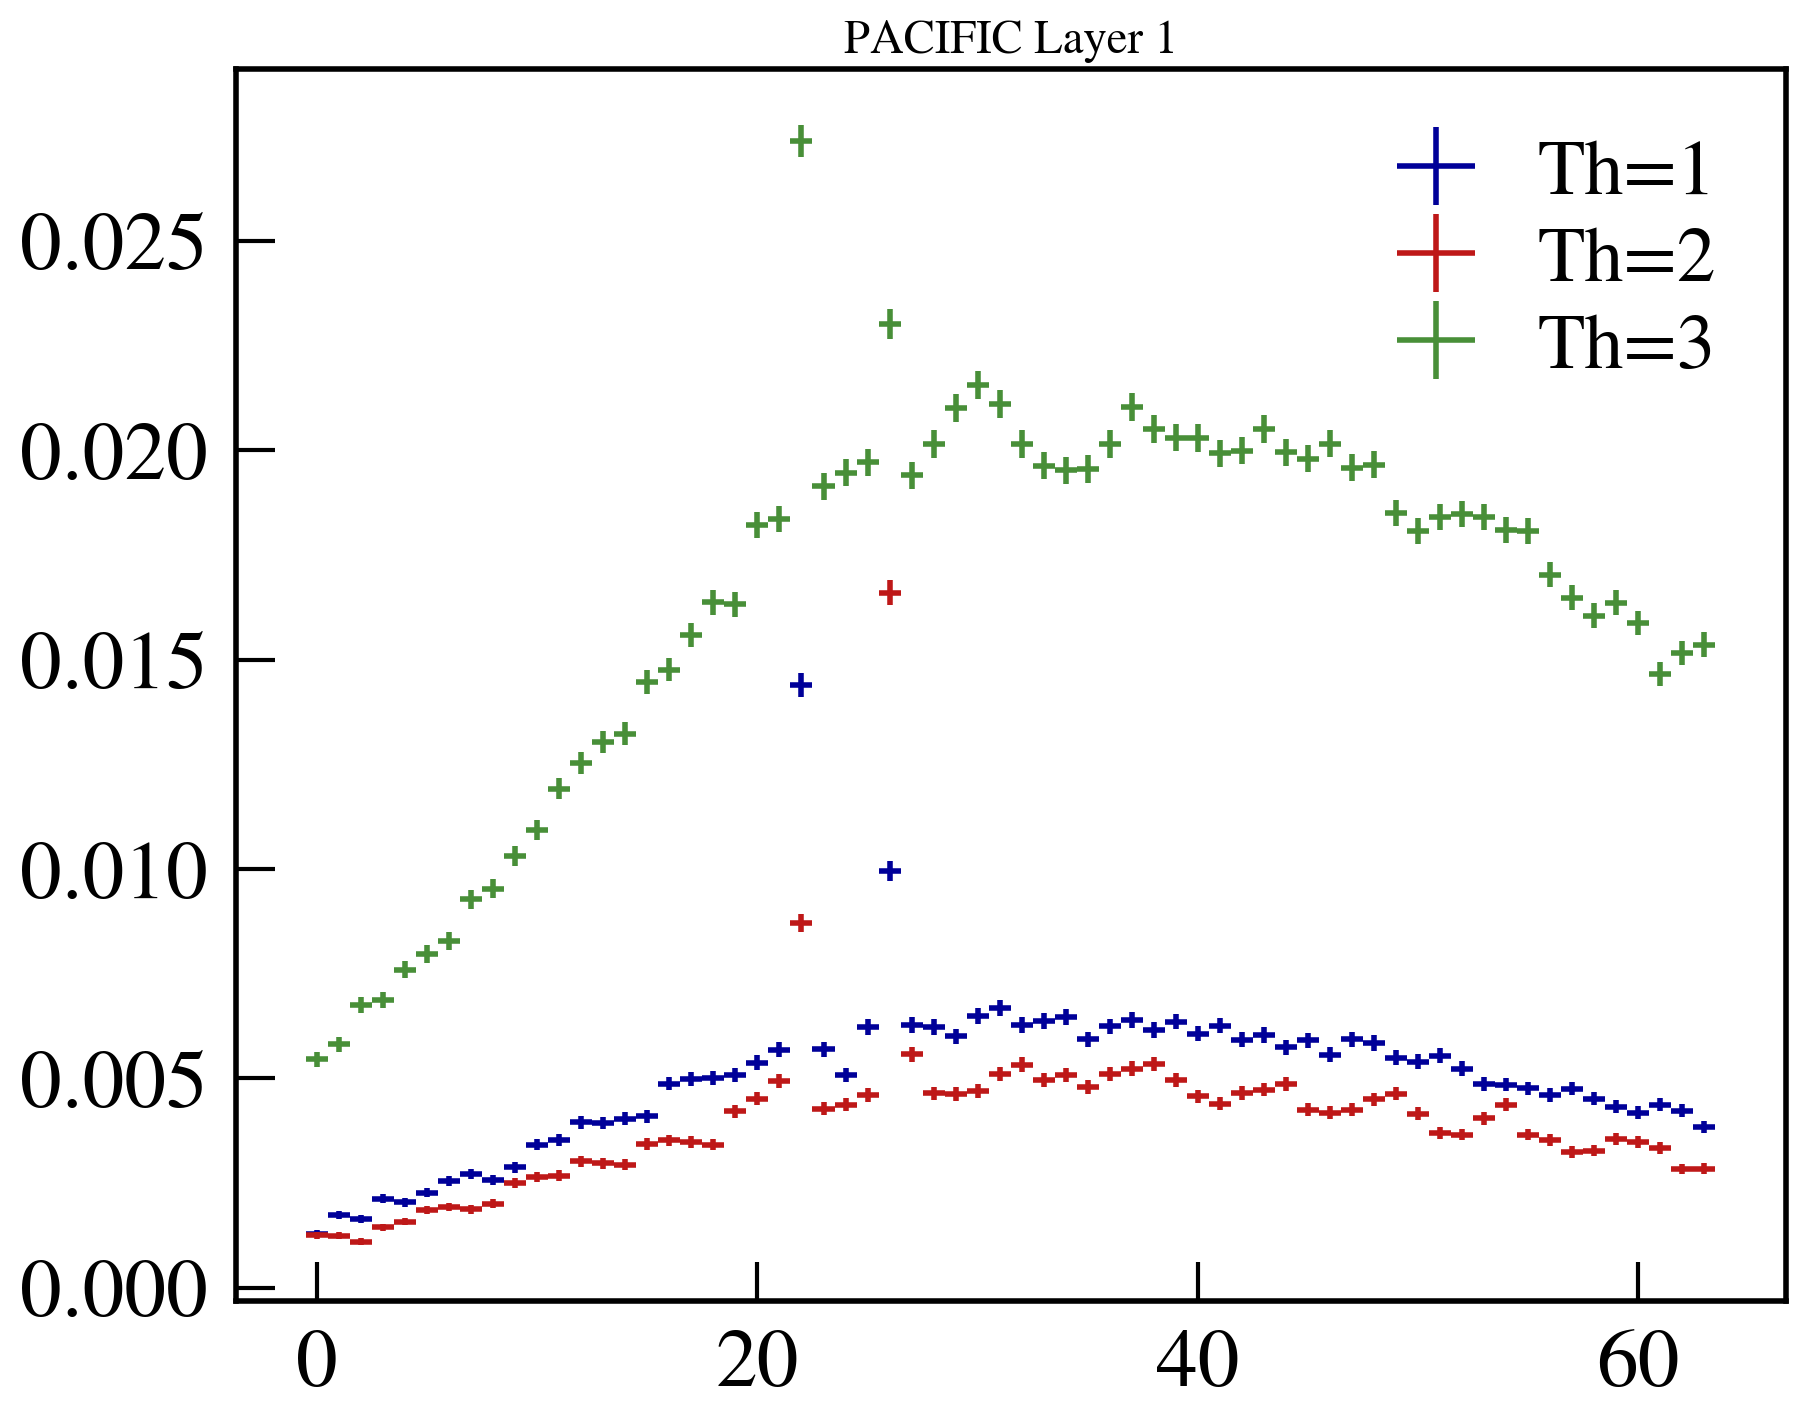

In [101]:
for layer, PACIFIC_sel in enumerate([PACIFIC_sel0, PACIFIC_sel1]):
    for th in [1,2,3]:
        ratio, chs, errlow, errup = TB.overthreshold_vs_channels(
            PACIFIC_sel[["Ch_{}".format(ch) for ch in range(64)]], th, "equal")
        plt.errorbar(chs, ratio, xerr=0.5, yerr=[errlow, errup], fmt=".", ms=0, label="Th={}".format(th))
        
    plt.title("PACIFIC Layer {}".format(layer))
    plt.legend()
    plt.show()
    plt.close()

# SPIROC Ratio plots

In [1]:
for layer, SPIROC_corr in enumerate([SPIROC0_corr, SPIROC1_corr]):
    pacific_like_data = TB.SPIROC2Ths(SPIROC_corr.values, Ths=thresholds)
    for th in [1,2,3]:
        ratio, chs, errlow, errup = TB.overthreshold_vs_channels(pacific_like_data, th, "equal")
        plt.errorbar(chs, ratio, xerr=0.5, yerr=[errlow, errup], fmt=".", ms=0, label="Th={}".format(th))
        
    plt.title("SPIROC Layer {} (Threshold {})".format(layer, PACIFIC_Thresholds))
    plt.legend()
    plt.show()
    plt.close()

NameError: name 'SPIROC0_corr' is not defined

# Overlay PACIFIC and SPIROC

In [103]:
from itertools import izip

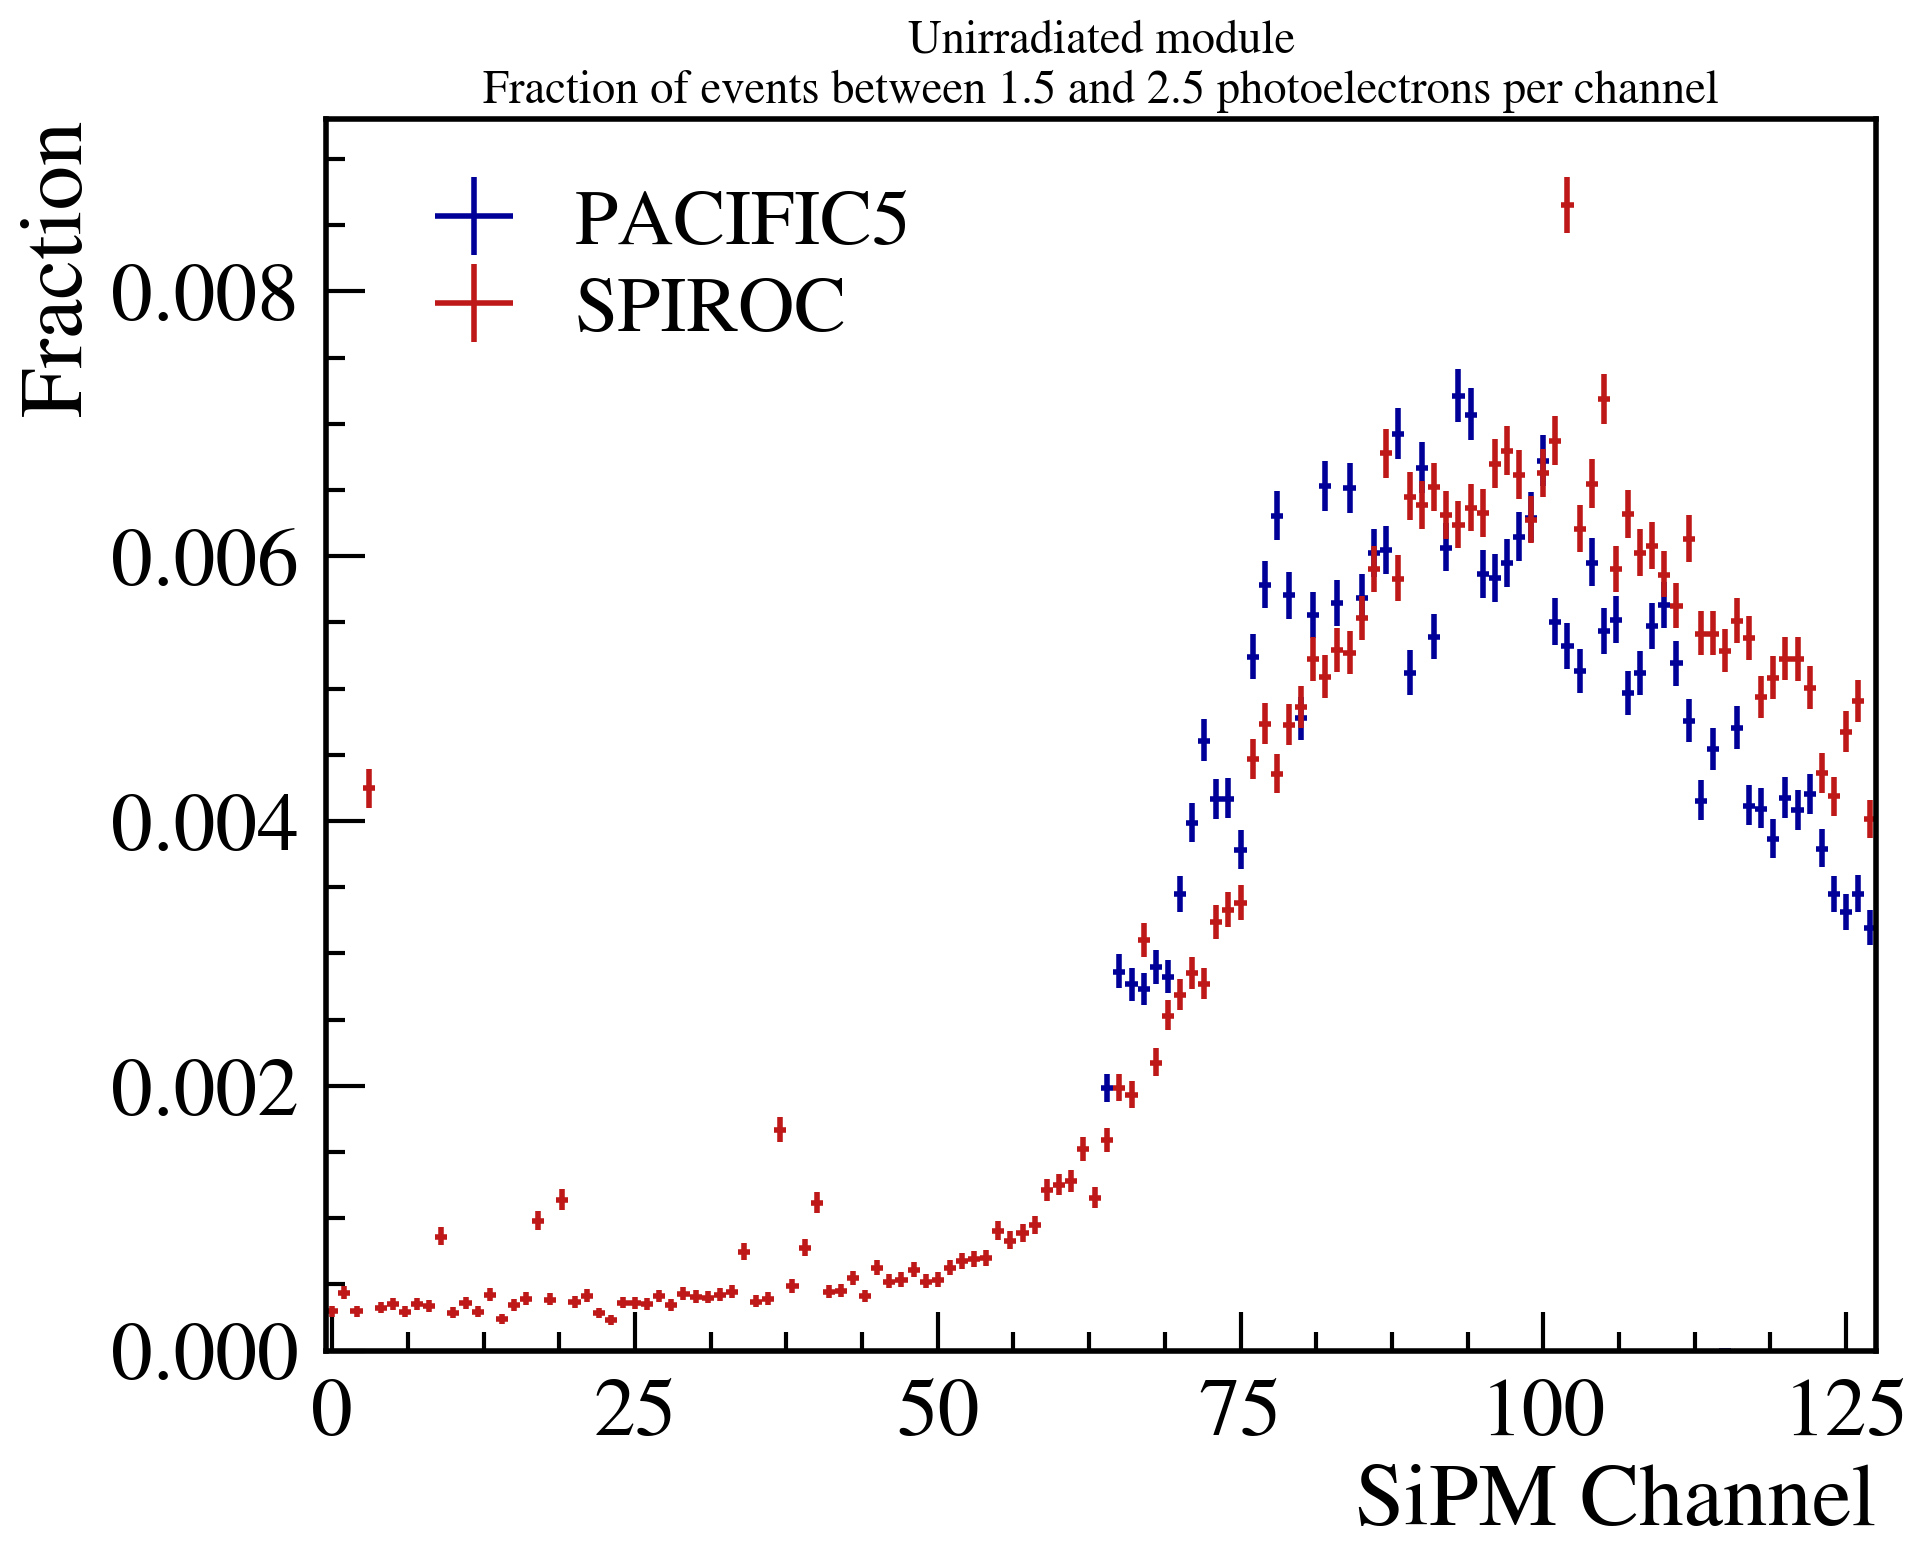

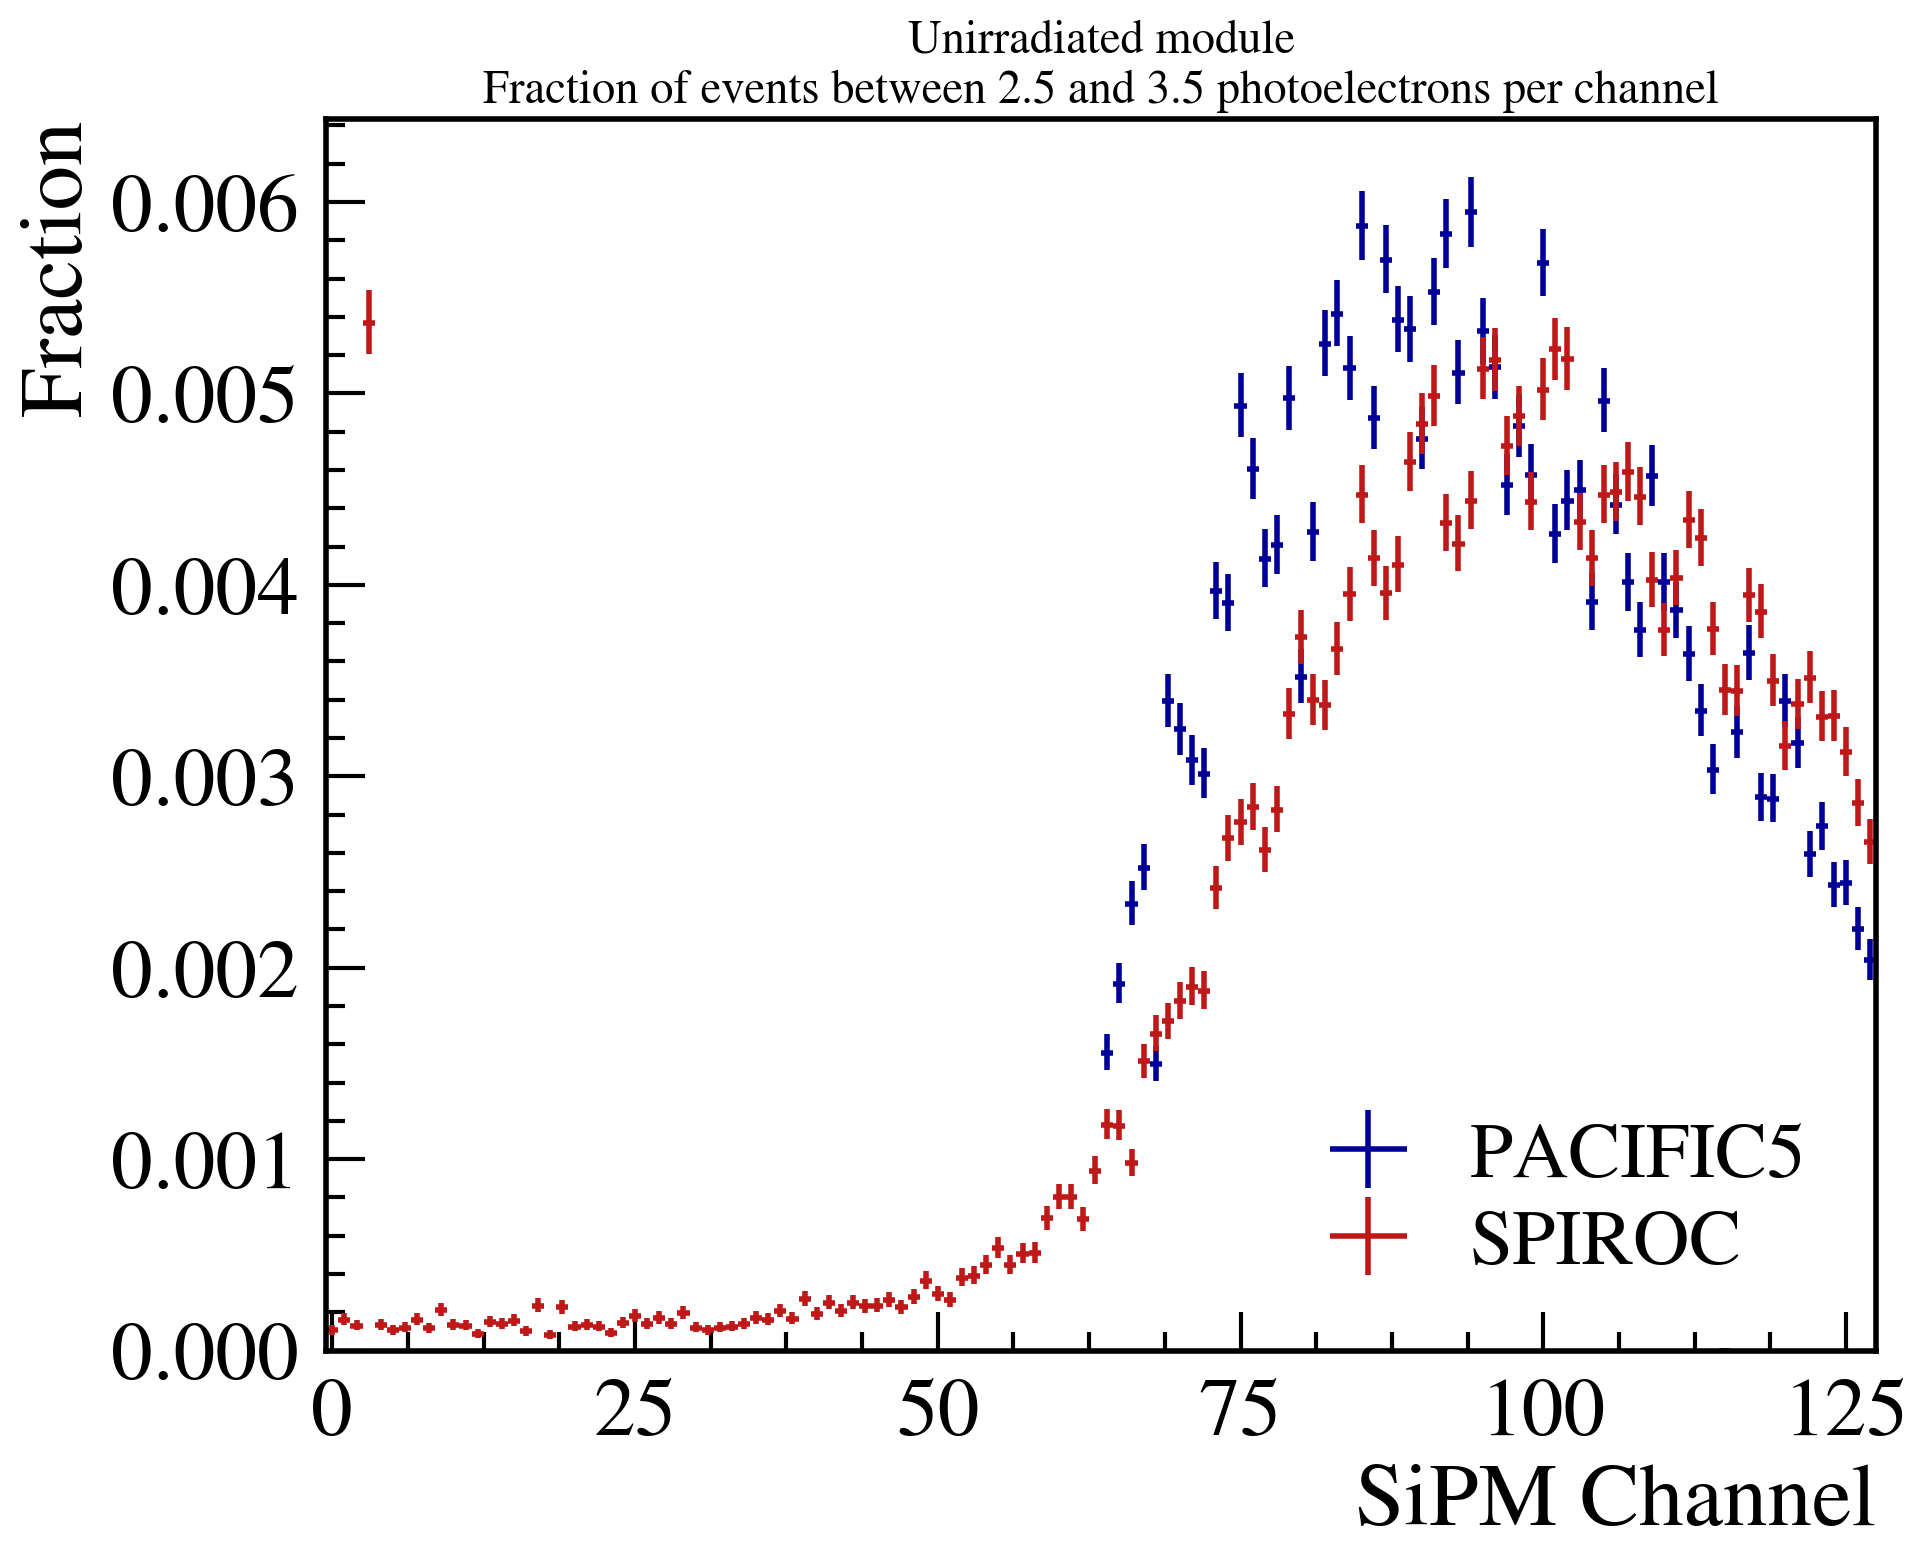

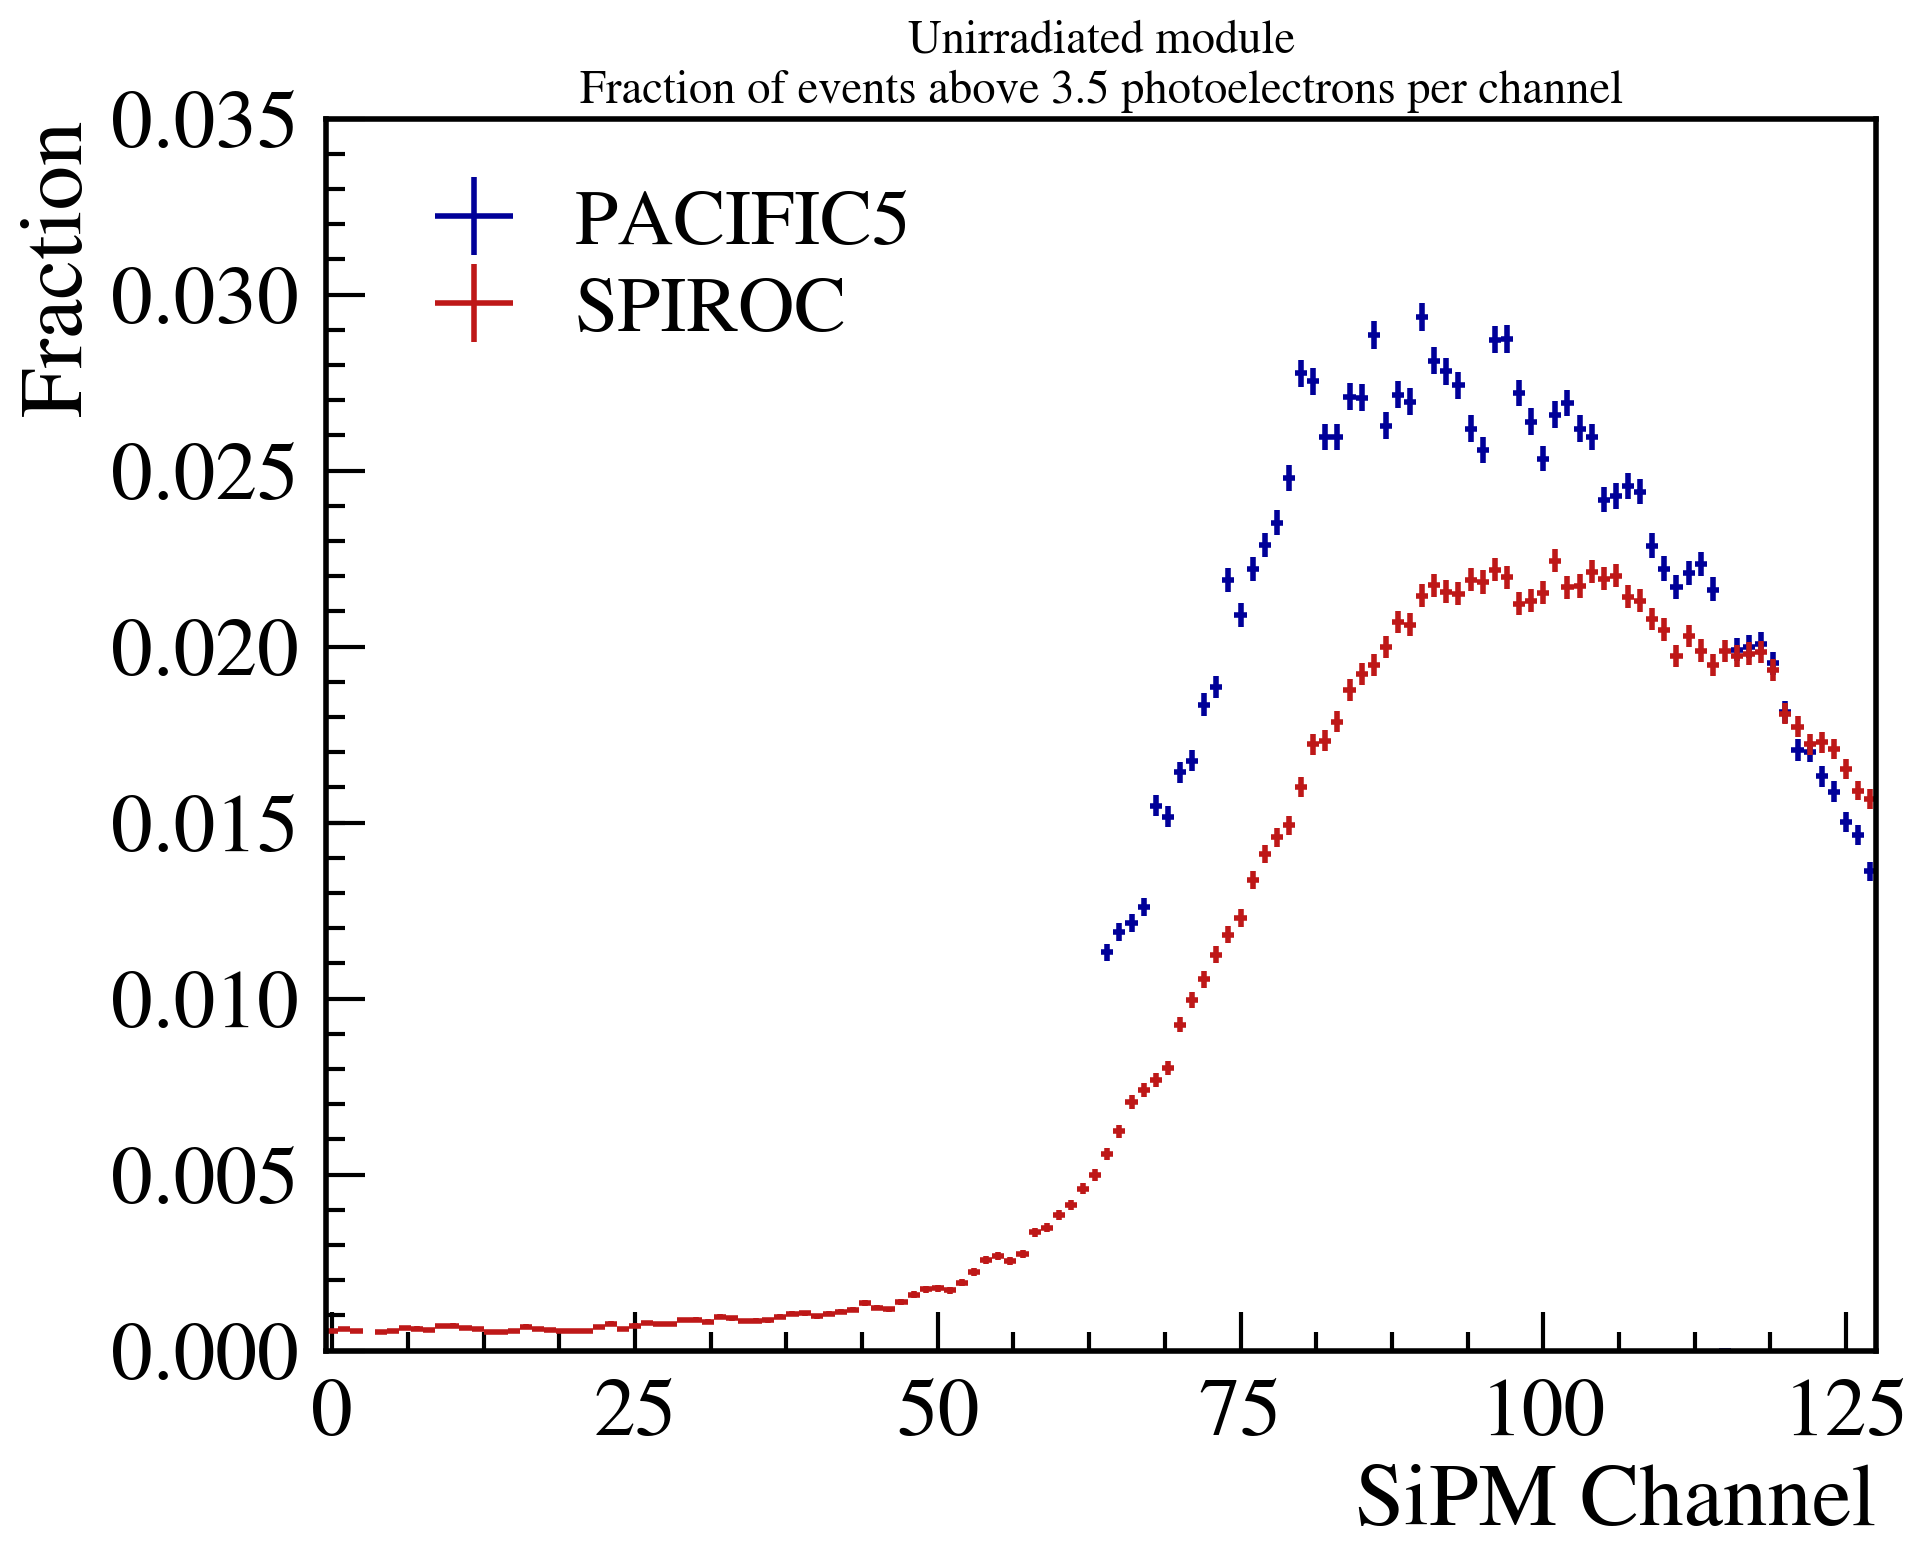

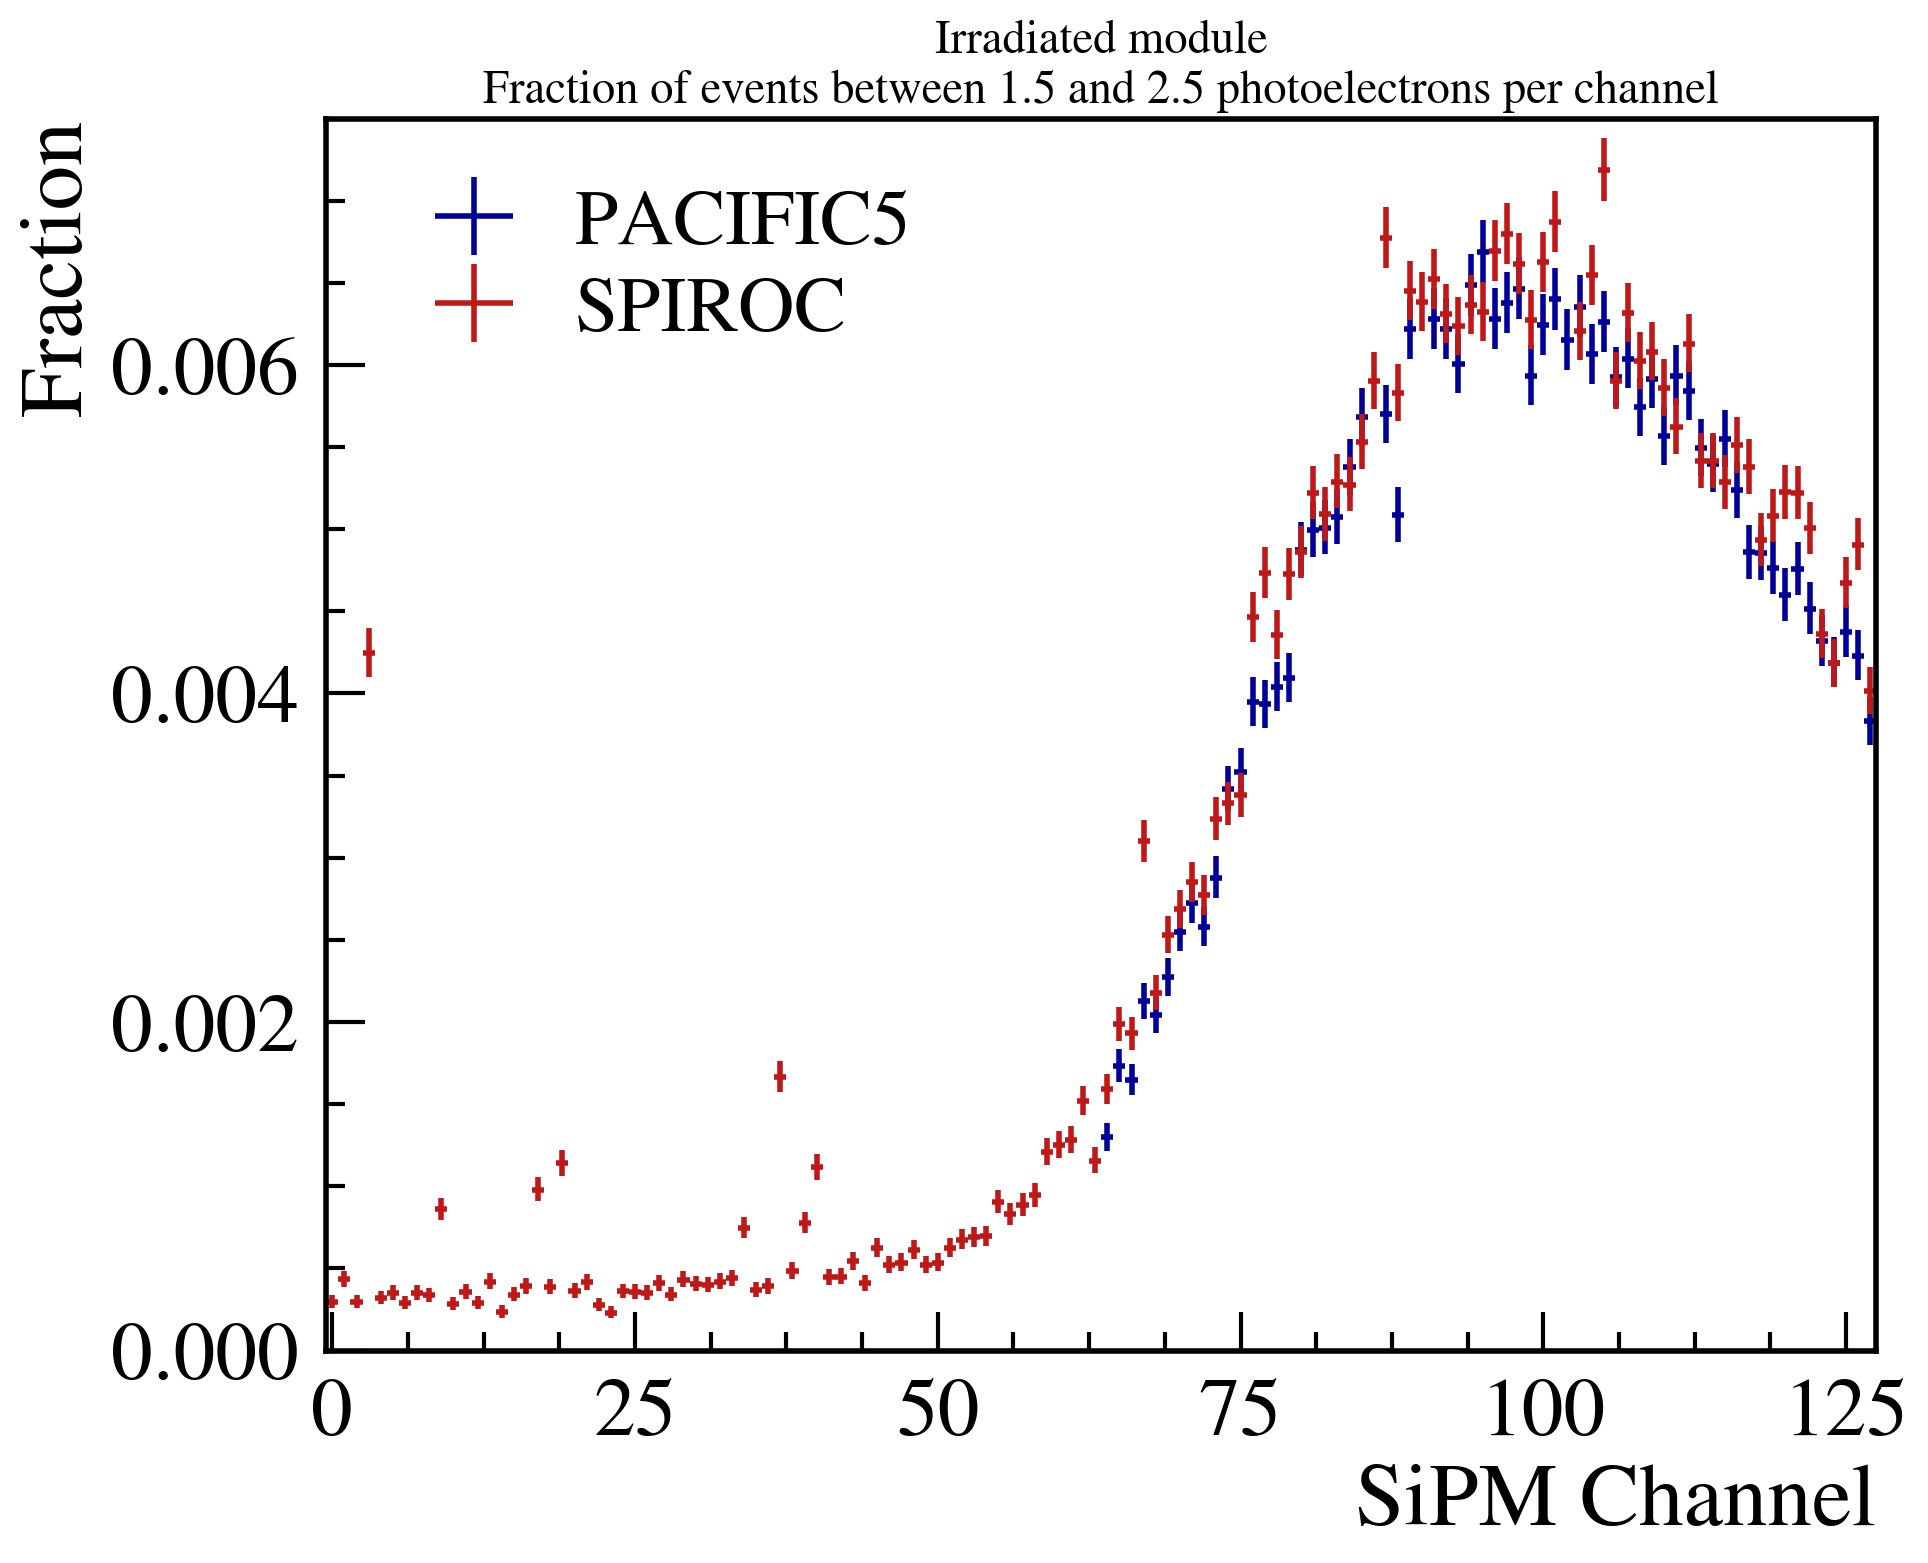

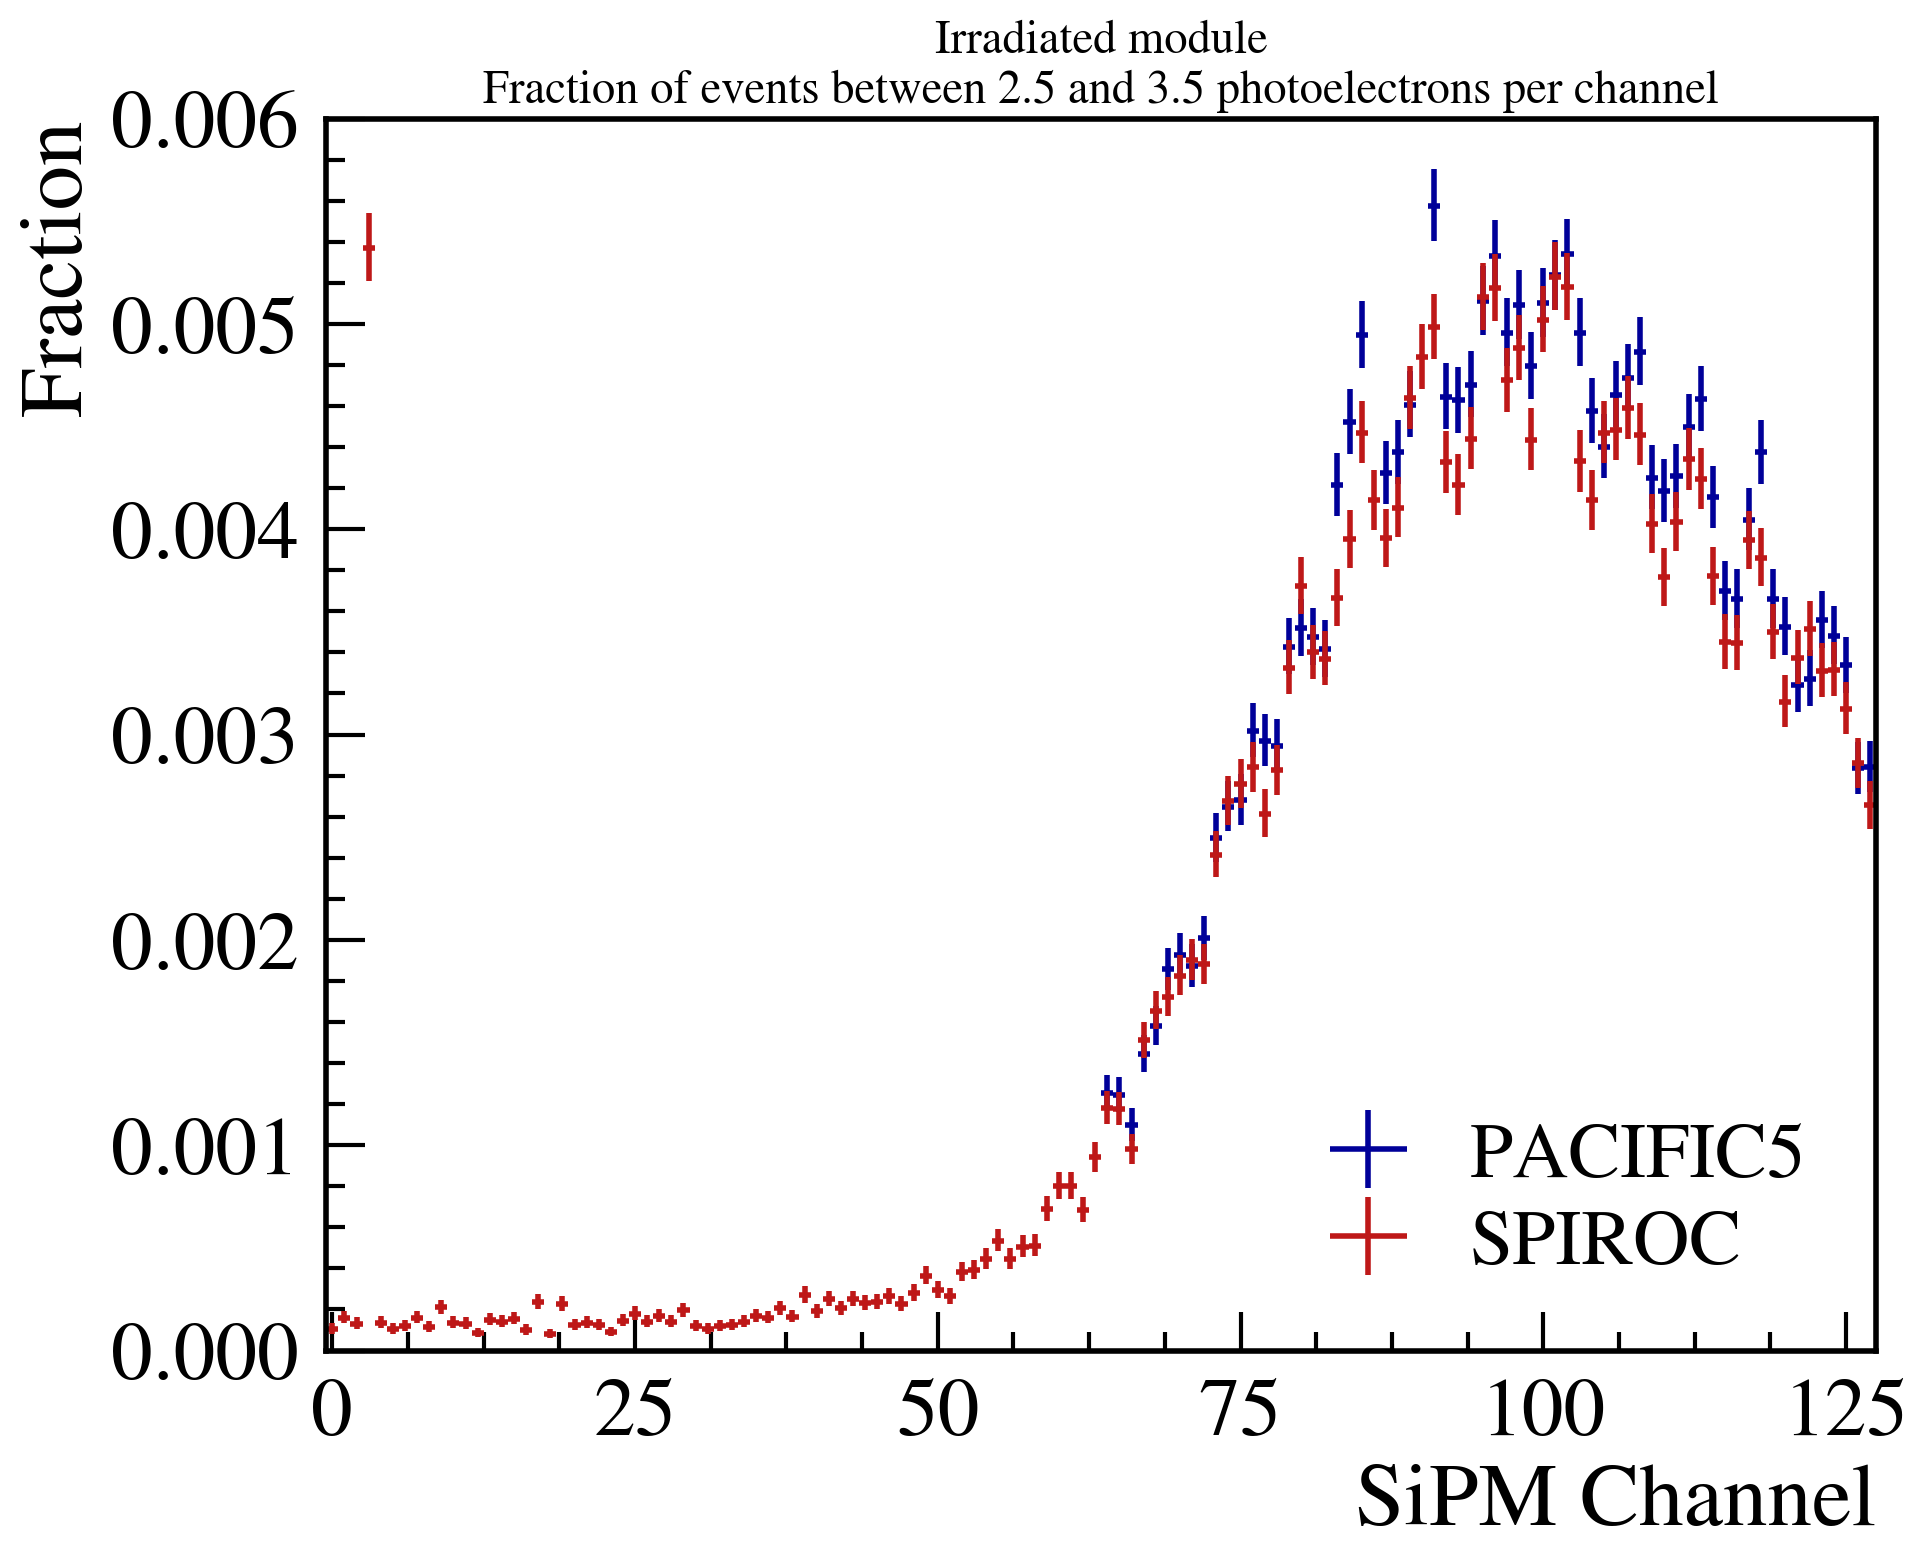

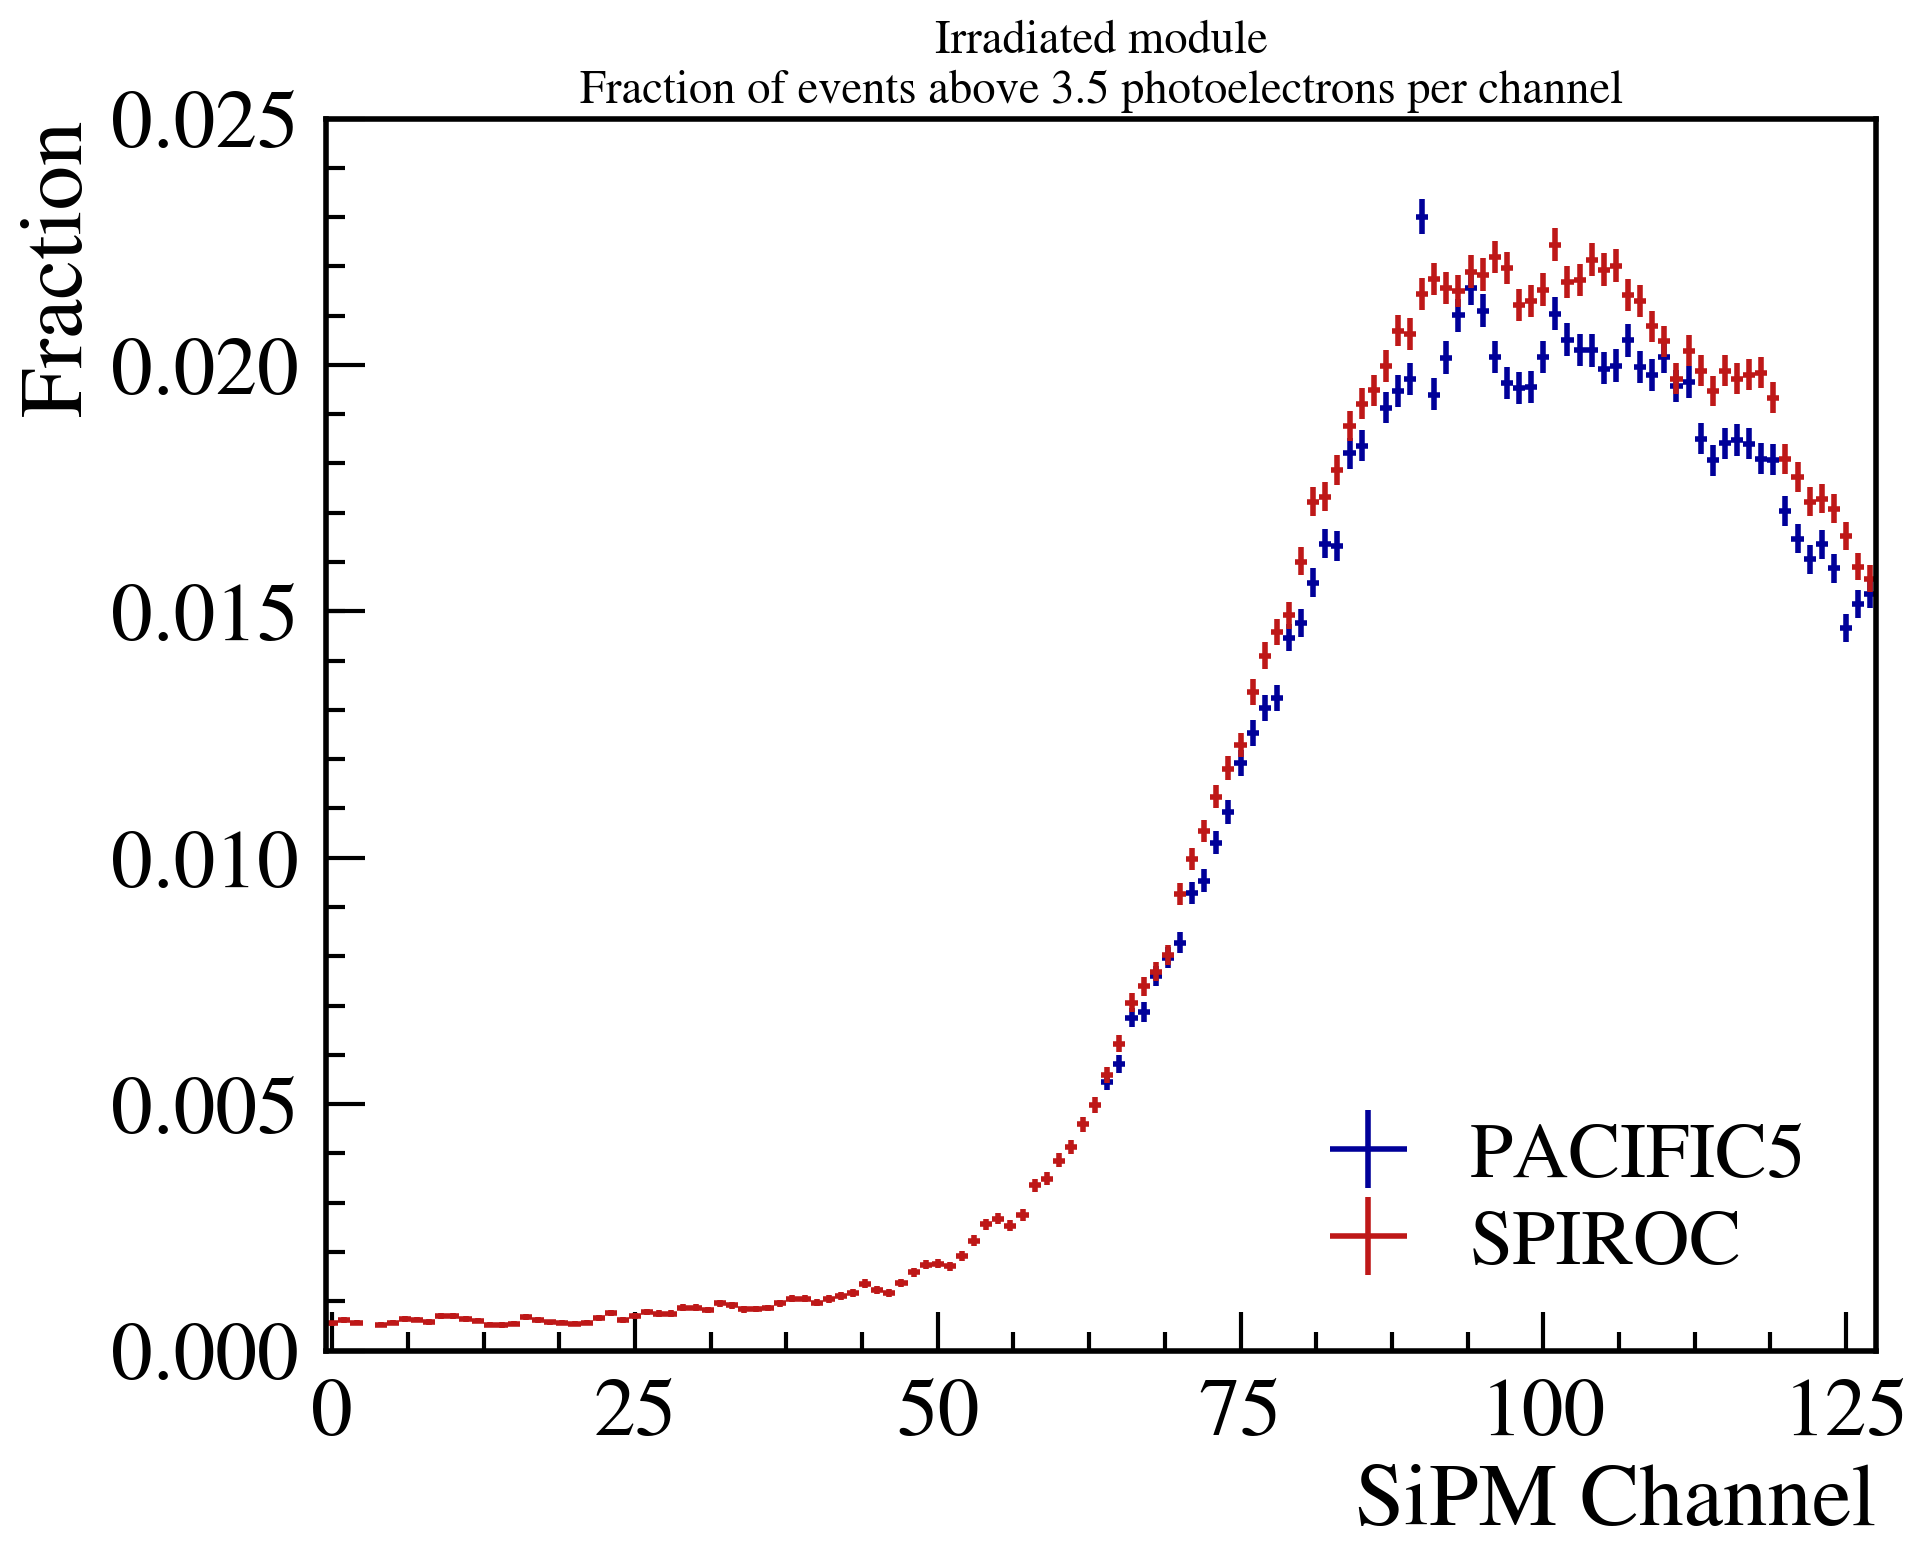

In [261]:
layer = 0

pp = PdfPages("Plots/Testplots/Overthresholdratio_SPIROC_vs_PACIFIC.pdf")

for PACIFIC_sel, SPIROC_corr in [(PACIFIC_sel0, SPIROC0_corr), (PACIFIC_sel1, SPIROC1_corr)]:
    SPIROC_pacific_like = TB.SPIROC2Ths(SPIROC_corr.values, Ths=thresholds)
    for th, color in izip([1,2,3], ["g", "r", "b"]):
        #PACIFIC
        ratio_pac, chs, errlow, errup = TB.overthreshold_vs_channels(
            PACIFIC_sel[["Ch_{}".format(ch) for ch in range(64)]], th, "equal")
        chs = np.asarray(chs)
        chs += 64  #Shift PACIFIC channels to match SPIROC channels
        dpl.errorbar(chs, ratio_pac, xerr=0.5, yerr=[errlow, errup], fmt=".", ms=0, label="PACIFIC5".format(th))
        
        #SPIROC
        ratio_spi, chs, errlow, errup = TB.overthreshold_vs_channels(pacific_like_data, th, "equal")
        dpl.errorbar(chs, ratio_spi, xerr=0.5, yerr=[errlow, errup], fmt=".", ms=0, label="SPIROC".format(th))
        
        title = "Unirradiated module" if layer==0 else "Irradiated module"
        if th<3:
            title += "\nFraction of events between {} and {} photoelectrons per channel".format(thresholds[th-1], 
                                                                                                thresholds[th])
        else:
            title += "\nFraction of events above {} photoelectrons per channel".format(thresholds[th-1])
        plt.title(title)
        dpl.xlabel("SiPM Channel")
        dpl.ylabel("Fraction")
        plt.ylim(0, plt.ylim()[1])
        if th==3 and layer==0:
            plt.ylim(0, 0.035)
        if th==1 and layer==1:
            plt.ylim(0, 0.0075)
        if th==2 and layer==1:
            plt.ylim(0, 0.006)
        if th==3 and layer==1:
            plt.ylim(0, 0.025)
        plt.xlim(-0.5,127.5)
        plt.legend()
        pp.savefig(bbox_inches="tight")

        plt.show()
        plt.close()
        
    layer += 1
    
pp.close()